In [1]:
import astropy.units as u
import astropy.table
from astropy.visualization import quantity_support
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import fiasco

from synthesizAR.atomic import equilibrium_ionization, non_equilibrium_ionization, effective_temperature
from synthesizAR.interfaces.ebtel import run_ebtel, read_xml

import pydrad.configure
import pydrad.configure.data
import pydrad.parse
import pydrad.visualize

# NEI Simulations

For the relevant ions in our bandpass, simulate wither non-equilibrium ionization is an important effect for us to consider when thinking about whether this lines will be observable.

## Impulsive Heating Simulations

In [5]:
ebtel_config = read_xml('/Users/wtbarnes/Documents/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')

In [6]:
ebtel_config

{'total_time': 5000.0,
 'tau': 1.0,
 'tau_max': 1e+300,
 'loop_length': 4000000000.0,
 'saturation_limit': 1.0,
 'force_single_fluid': False,
 'use_c1_loss_correction': True,
 'use_c1_grav_correction': True,
 'use_flux_limiting': False,
 'calculate_dem': False,
 'save_terms': False,
 'use_adaptive_solver': False,
 'output_filename': 'ebtel++_results_file.txt',
 'adaptive_solver_error': 1e-06,
 'adaptive_solver_safety': 0.5,
 'c1_cond0': 2.0,
 'c1_rad0': 0.6,
 'helium_to_hydrogen_ratio': 0.075,
 'surface_gravity': 1.0,
 'dem': OrderedDict([('use_new_method', True),
              ('temperature', {'bins': 451, 'log_min': 4, 'log_max': 8.5})]),
 'heating': OrderedDict([('background', 3.5e-05),
              ('partition', 1.0),
              ('events',
               [{'event': {'magnitude': 0.1,
                  'rise_start': 0.0,
                  'rise_end': 50.0,
                  'decay_start': 50.0,
                  'decay_end': 100.0}},
                {'event': {'magnitude': 0.15,

In [87]:
total_time = 1.3e4 * u.s
loop_length = 40 * u.Mm
duration = 200 * u.s
t_0 = 100 * u.s
wait_time = 1500 * u.s
number_events = 1
heating_rate = 0.075 * u.Unit('erg cm-3 s-1')
heating_rate_bg = 2.75e-5 * u.Unit('erg cm-3 s-1')
start_times = t_0 + (duration + wait_time) * np.arange(number_events)
ebtel_config['total_time'] = total_time.to_value('s')
ebtel_config['loop_length'] = loop_length.to_value('cm')
ebtel_config['use_flux_limiting']= True
ebtel_config['use_adaptive_solver'] = True
ebtel_config['saturation_limit'] = 1
ebtel_config['adaptive_solver_error'] = 1e-10
#config['adaptive_sover_safety'] = 0.1
events = []
for st in start_times:
    events.append(
        {'event': {'magnitude': heating_rate.to_value('erg cm-3 s-1'),
                   'rise_start': st.to_value('s'),
                   'rise_end': (st + duration/2).to_value('s'),
                   'decay_start': (st + duration/2).to_value('s'),
                   'decay_end': (st + duration).to_value('s')}}
    )
ebtel_config['heating']['events'] = events
ebtel_config['heating']['background'] = heating_rate_bg

In [88]:
simulation = run_ebtel(ebtel_config, '/Users/wtbarnes/Documents/codes/ebtelPlusPlus/')
time = simulation['time'] * u.s
heat = simulation['heat'] * u.Unit('erg cm-3 s-1')
electron_temperature = simulation['electron_temperature'] * u.K
density = simulation['density'] * u.Unit('cm-3')

In [83]:
simulation.keys()

dict_keys(['time', 'electron_temperature', 'ion_temperature', 'density', 'electron_pressure', 'ion_pressure', 'velocity', 'heat'])

In [84]:
electron_temperature[0]

<Quantity 1007727. K>

In [85]:
density[0] / 1e9

<Quantity 0.1771306 1 / cm3>

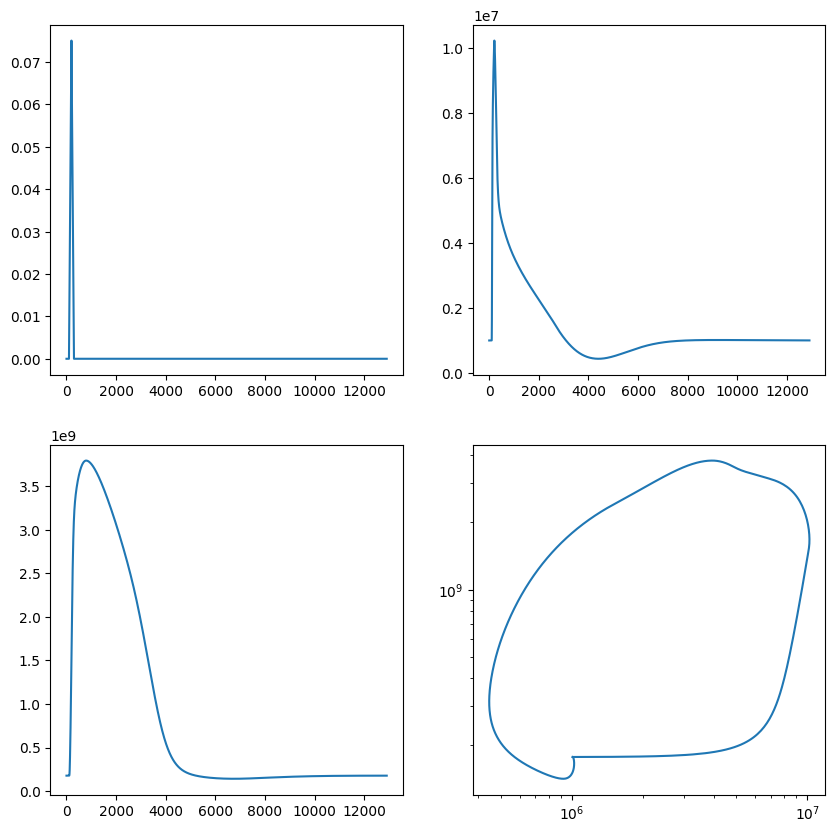

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
ax.plot(time, heat)
ax = fig.add_subplot(222)
ax.plot(time, electron_temperature)
ax = fig.add_subplot(223)
ax.plot(time, density)
ax = fig.add_subplot(224)
ax.plot(electron_temperature, density)
ax.set_yscale('log')
ax.set_xscale('log')

## Identify Ions

In [13]:
line_list = astropy.table.QTable.read('../data/moxsi-line-list.asdf')

In [14]:
line_list[line_list.argsort(keys='intensity_scaled (coronal)_flare_ext', reverse=True)][['ion name', 'wavelength']].pprint_all()

ion name     wavelength    
              Angstrom     
-------- ------------------
 Fe XVII 15.012999534606934
 Fe XVII 17.051000595092773
  Fe XXI 12.281999588012695
 Fe XVII  17.09600067138672
 Fe XVII  16.77560043334961
Fe XXIII 11.737000465393066
Fe XVIII 14.203900337219238
  O VIII 18.967100143432617
 Fe XXII 11.767499923706055
 Fe XXIV 11.170900344848633
Fe XVIII  16.07200050354004
  Fe XIX 13.524900436401367
 Fe XXIV 10.619000434875488
   Fe XX  12.82699966430664
 Fe XVII  15.26200008392334
Fe XXIII  12.16100025177002
Fe XVIII 14.208800315856934
  Mg XII   8.41919994354248
   Fe XX 12.845399856567383
  Si XIV 6.1803998947143555
Fe XVIII  17.62179946899414
Fe XVIII   16.0049991607666
 Si XIII  6.647900104522705
Fe XXIII 10.979999542236328
Fe XVIII 15.622099876403809
 Fe XXIV 11.029000282287598
  O VIII  18.97249984741211
  Fe XIX 13.506400108337402
Fe XVIII 14.373000144958496
 Fe XXIV 11.426300048828125
  Fe XIX 16.109899520874023
  Fe XXI 13.506999969482422
 Fe XXIV 10.66300010

In [15]:
hot_line_table = line_list[np.logical_and(line_list['max temperature_flare_ext'] > 3 * u.MK,
                                          line_list['max temperature_flare_ext'] < 12 * u.MK)]
hot_line_table[hot_line_table.argsort(keys='intensity_scaled (coronal)_flare_ext', reverse=True)][
    ['ion name', 'wavelength', 'intensity_scaled (coronal)_flare_ext']].pprint_all()

ion name     wavelength     intensity_scaled (coronal)_flare_ext
              Angstrom                                          
-------- ------------------ ------------------------------------
 Fe XVII 15.012999534606934                                  1.0
 Fe XVII 17.051000595092773                   0.7990830377280506
 Fe XVII  17.09600067138672                   0.7228795890158841
 Fe XVII  16.77560043334961                   0.5949798048043987
Fe XVIII 14.203900337219238                   0.4896022804982188
  O VIII 18.967100143432617                   0.4122510037782132
Fe XVIII  16.07200050354004                  0.33495904420023276
  Fe XIX 13.524900436401367                   0.3077585024598136
   Fe XX  12.82699966430664                  0.29560189950656485
 Fe XVII  15.26200008392334                  0.28855152685279967
Fe XVIII 14.208800315856934                  0.27566060993420255
   Fe XX 12.845399856567383                    0.266082030490089
Fe XVIII  17.621799468994

In [16]:
elements = np.unique(hot_line_table['element'])

## Equilibrium Ionization

In [17]:
temperature_grid = 10**np.arange(4,8,0.001) * u.K

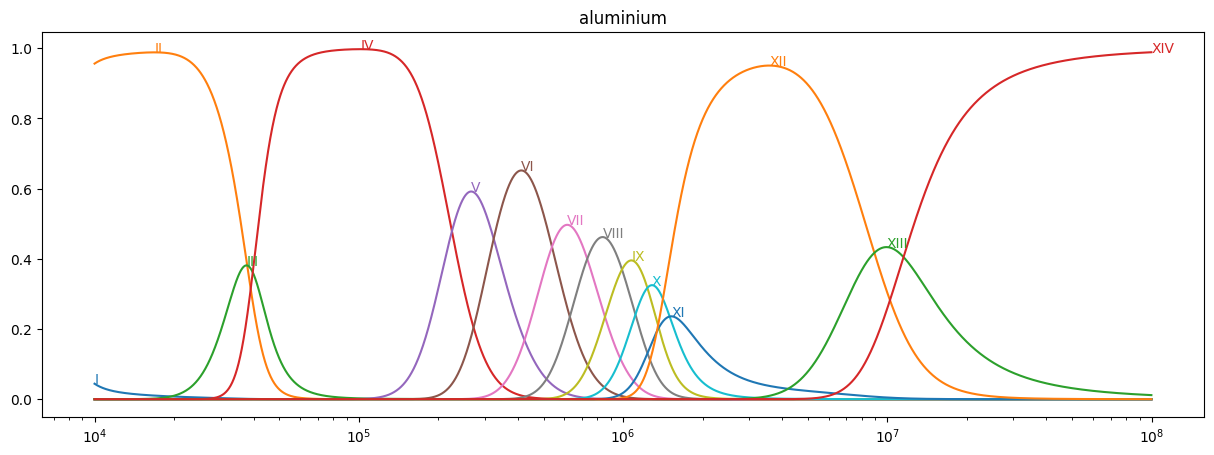

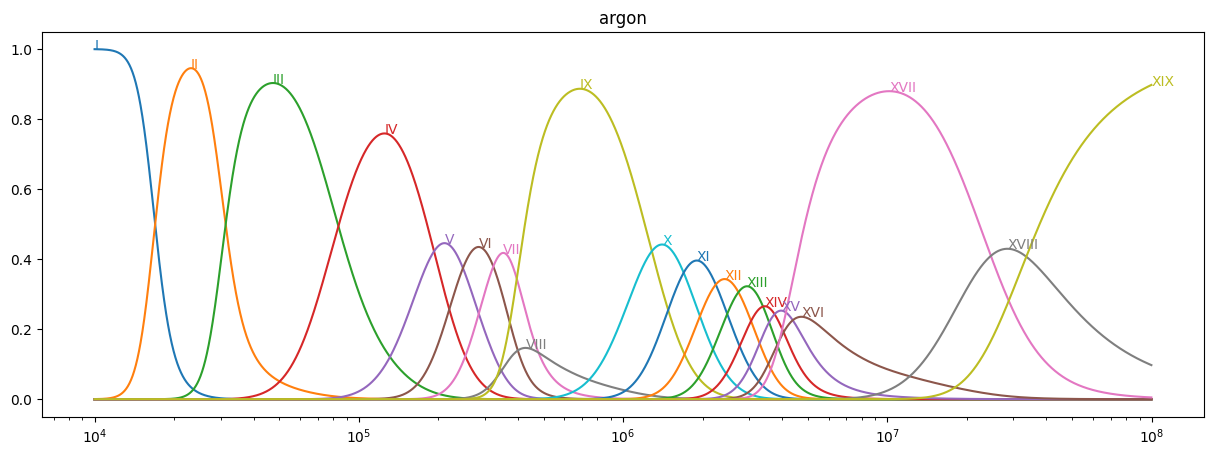

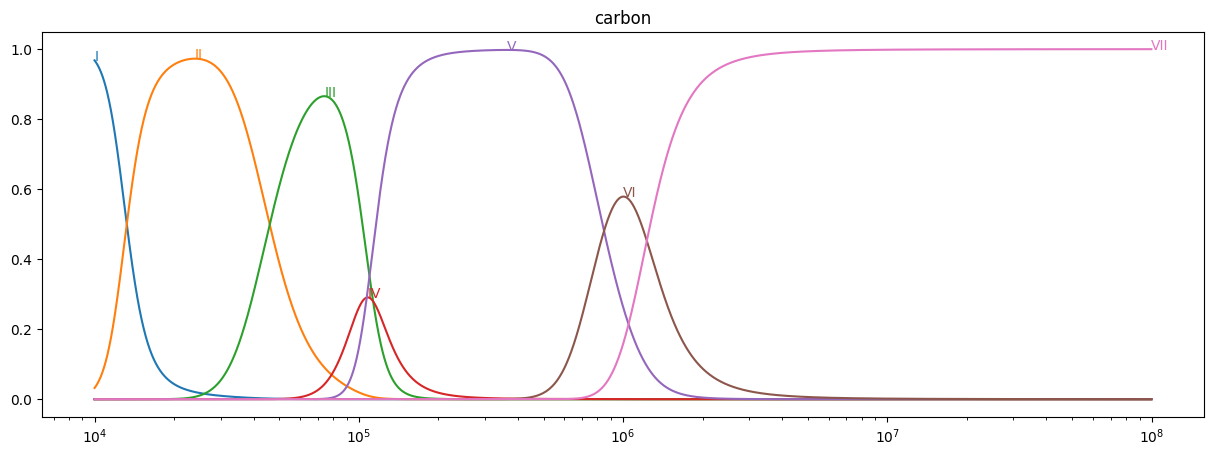

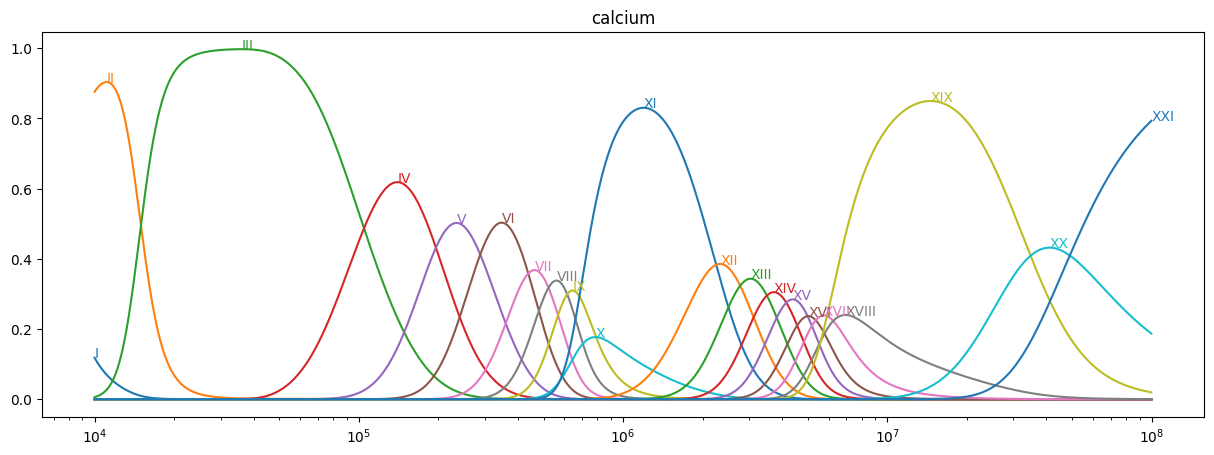

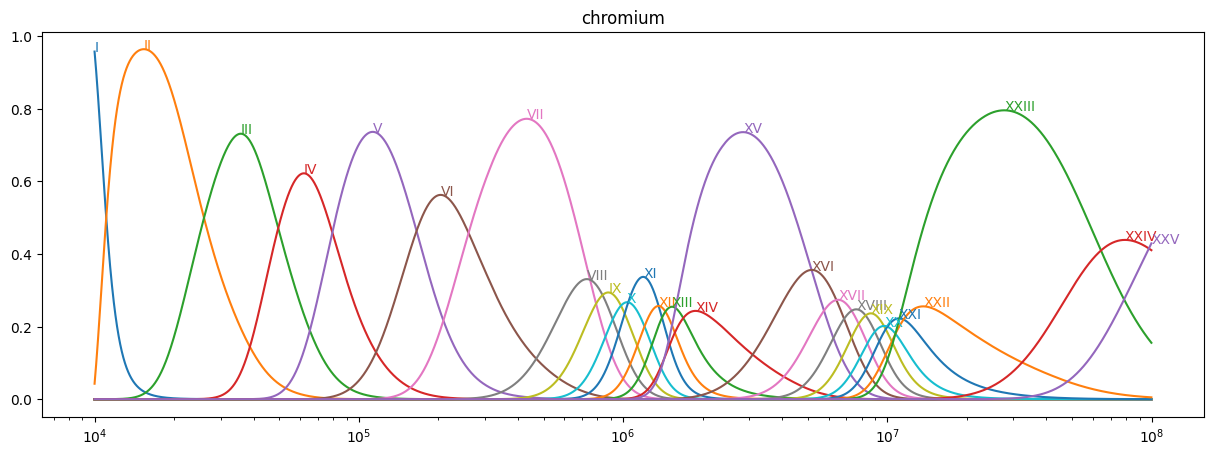

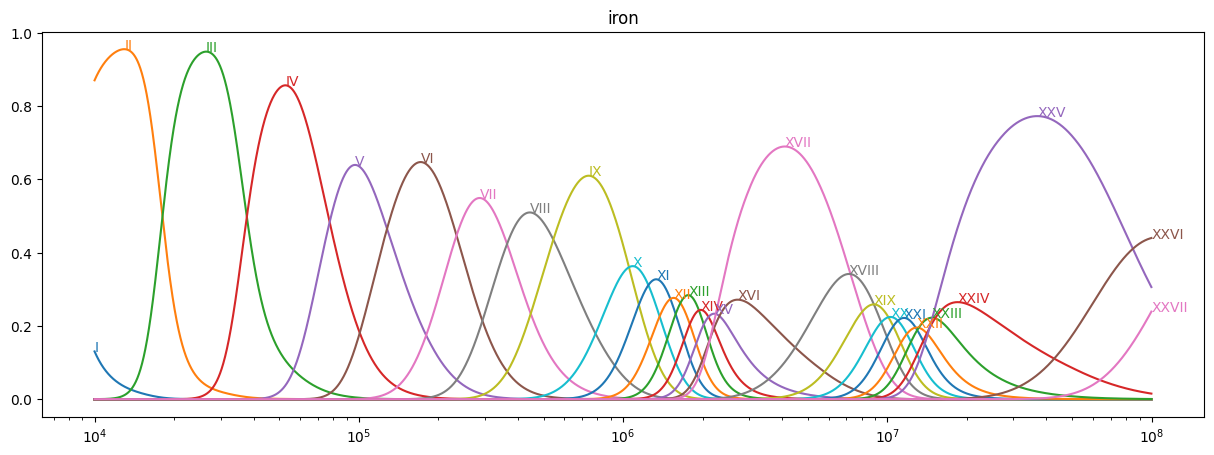

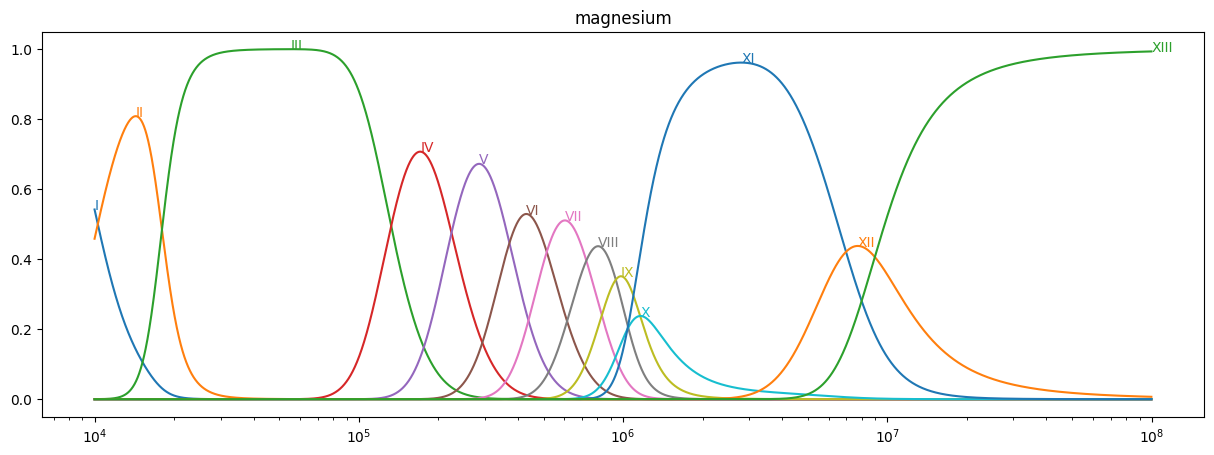

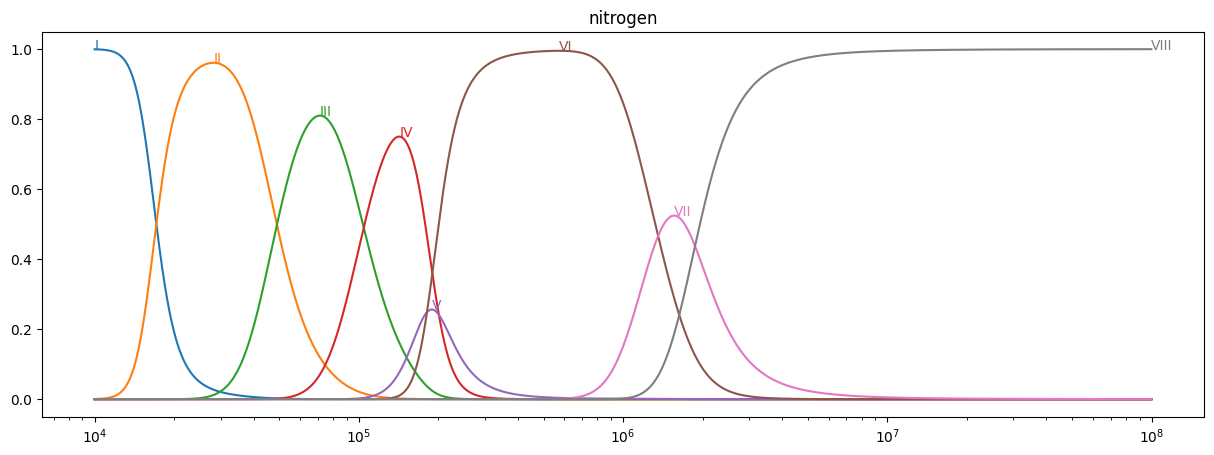

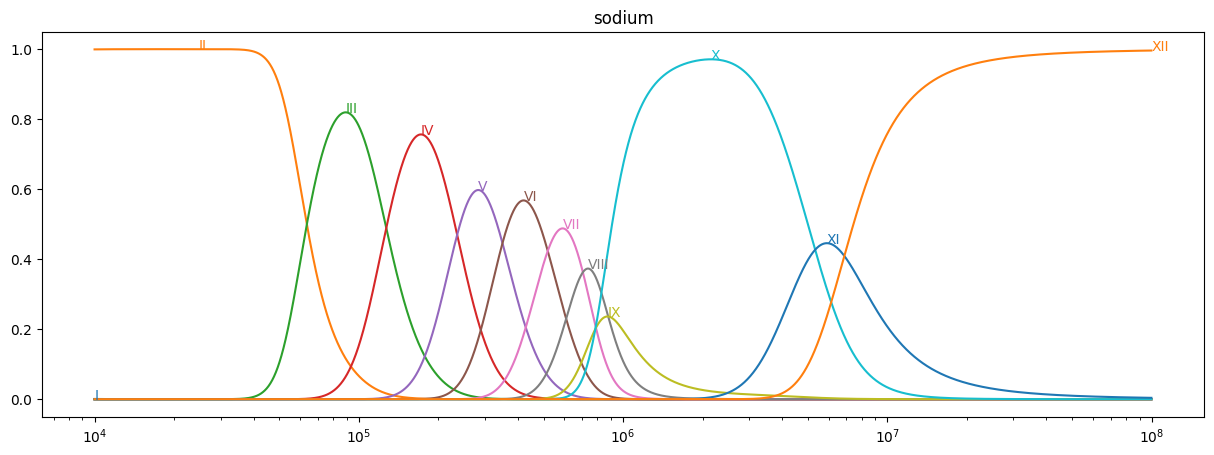

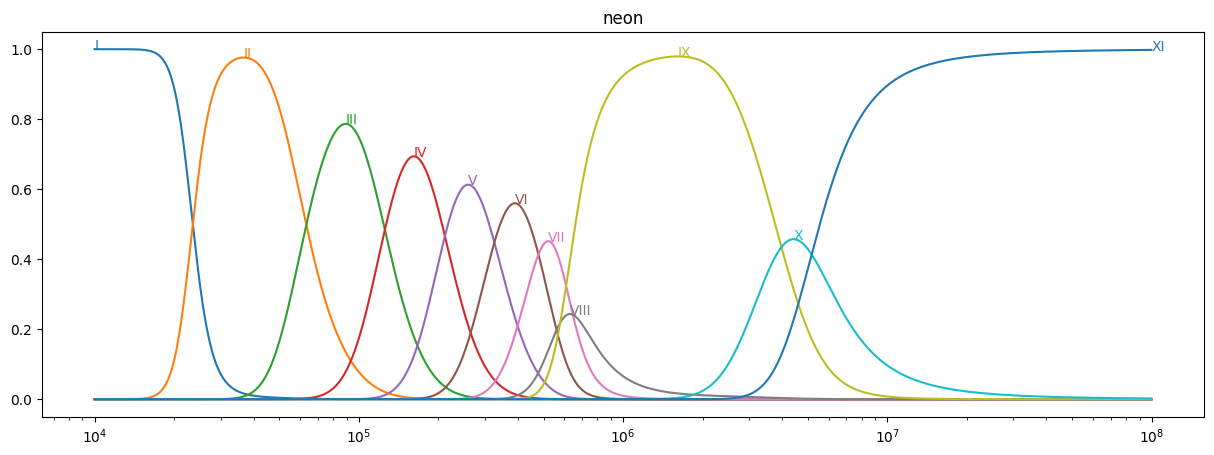

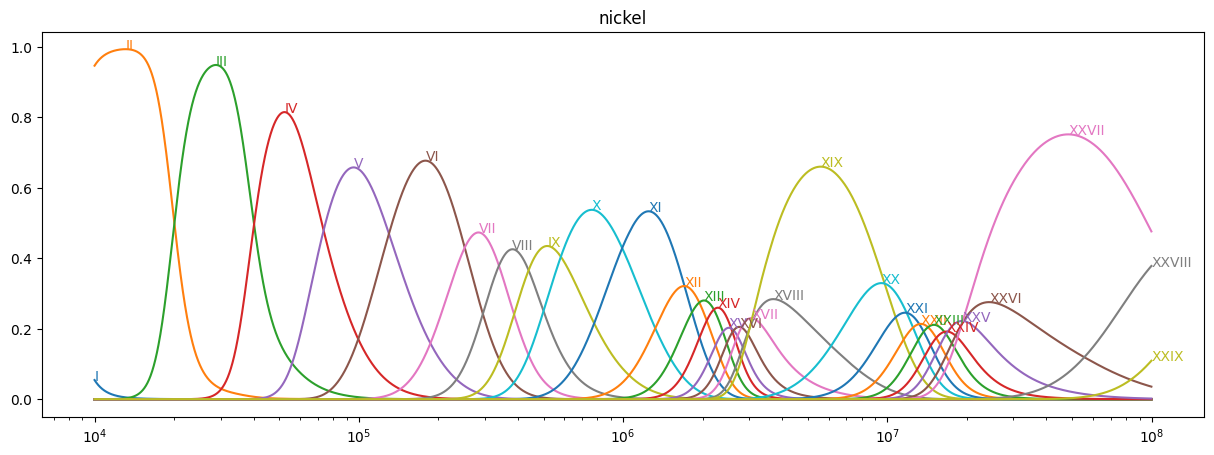

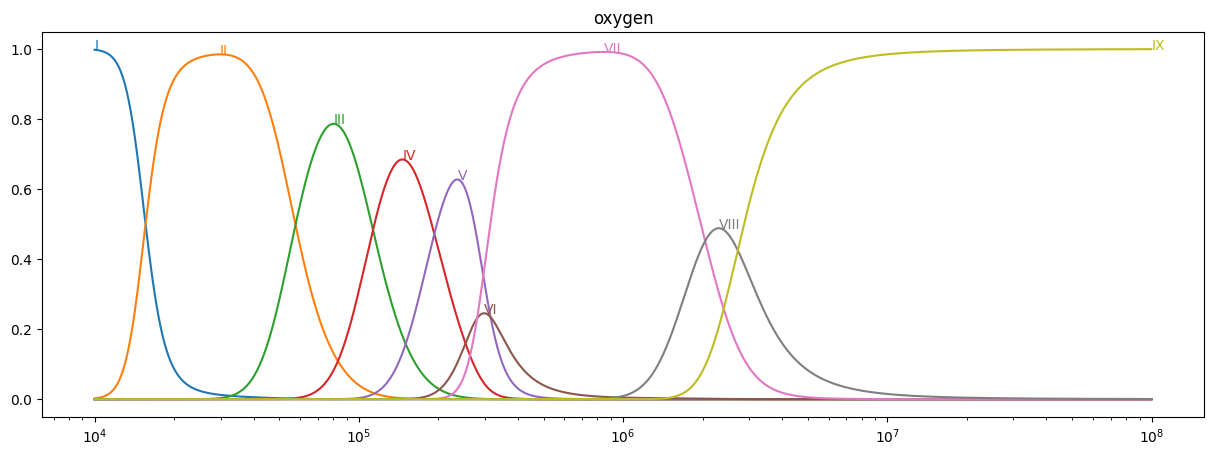

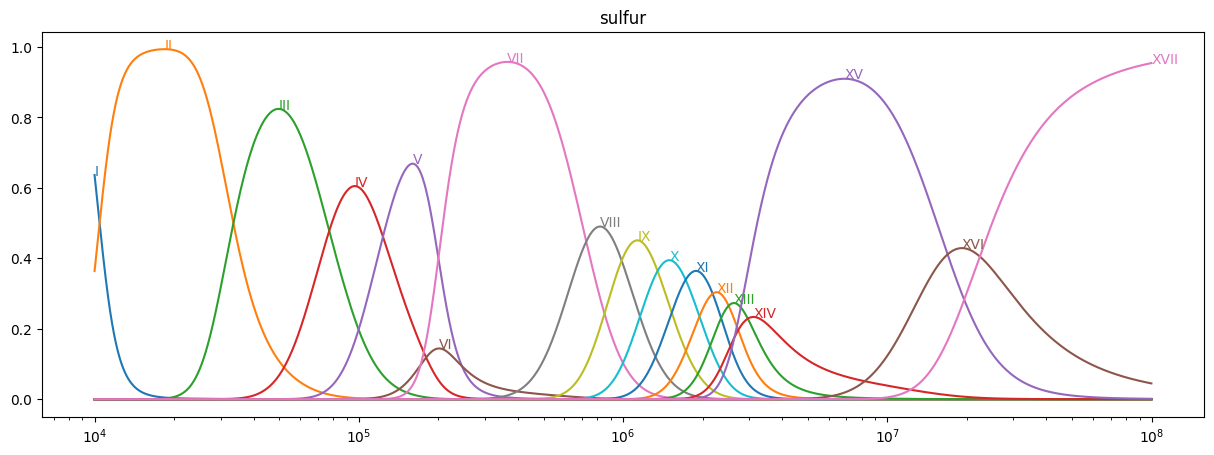

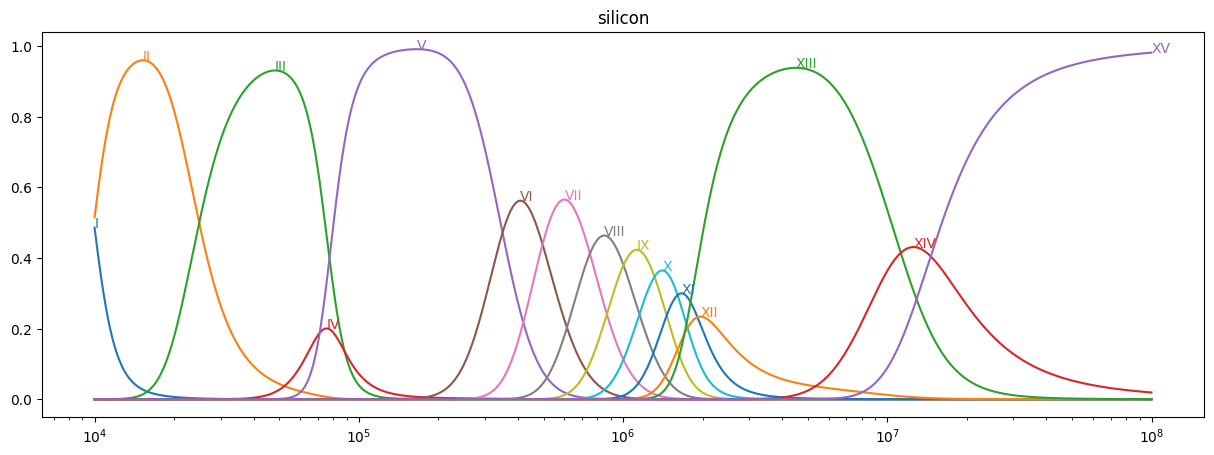

In [18]:
for el_name in elements:
    el = fiasco.Element(el_name, temperature_grid)
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    for i in el:
        ioneq = el.equilibrium_ionization[:, i.charge_state]
        l, = ax.plot(el.temperature, ioneq)
        ax.text(el.temperature[ioneq.argmax()].value, ioneq.max().value, i.ionization_stage_roman, color=l.get_color())
    ax.set_title(el.element_name)
    ax.set_xscale('log')

In [454]:
fe = fiasco.Element('iron', temperature_grid)

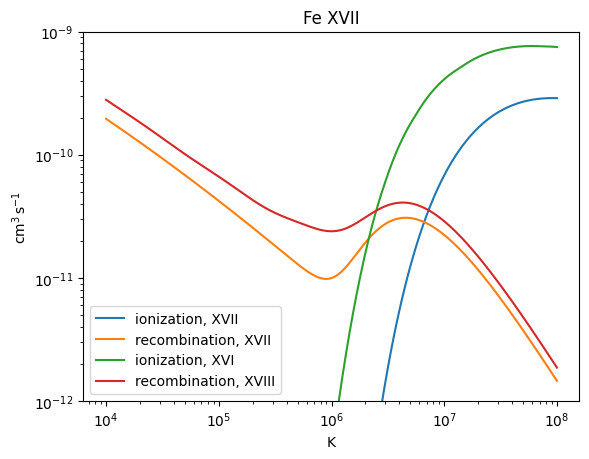

In [455]:
istate = 17
cur_ion = fe[istate-1]
with quantity_support():
    plt.plot(fe.temperature, cur_ion.ionization_rate, label=f'ionization, {cur_ion.ionization_stage_roman}')
    plt.plot(fe.temperature, cur_ion.recombination_rate, label=f'recombination, {cur_ion.ionization_stage_roman}')
    plt.plot(fe.temperature, fe[istate-2].ionization_rate, label=f'ionization, {fe[istate-2].ionization_stage_roman}')
    plt.plot(fe.temperature, fe[istate].recombination_rate, label=f'recombination, {fe[istate].ionization_stage_roman}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-12,1e-9)
plt.title(cur_ion.ion_name_roman)
plt.legend()

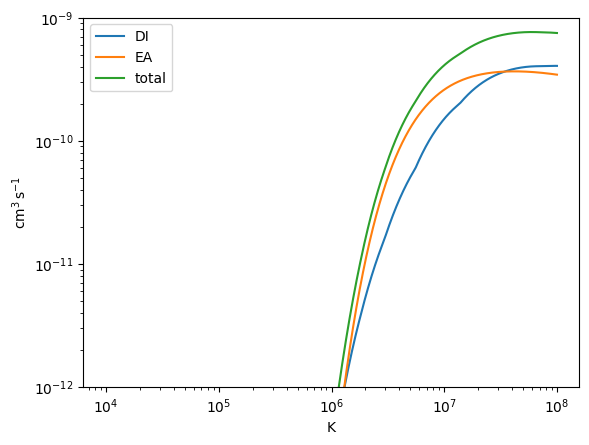

In [456]:
with quantity_support():
    plt.plot(fe[15].temperature, fe[15].direct_ionization_rate, label='DI')
    plt.plot(fe[15].temperature, fe[15].excitation_autoionization_rate, label='EA')
    plt.plot(fe[15].temperature, fe[15].direct_ionization_rate+fe[15].excitation_autoionization_rate, label='total')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-12,1e-9)
plt.legend()

## Simulate NEI

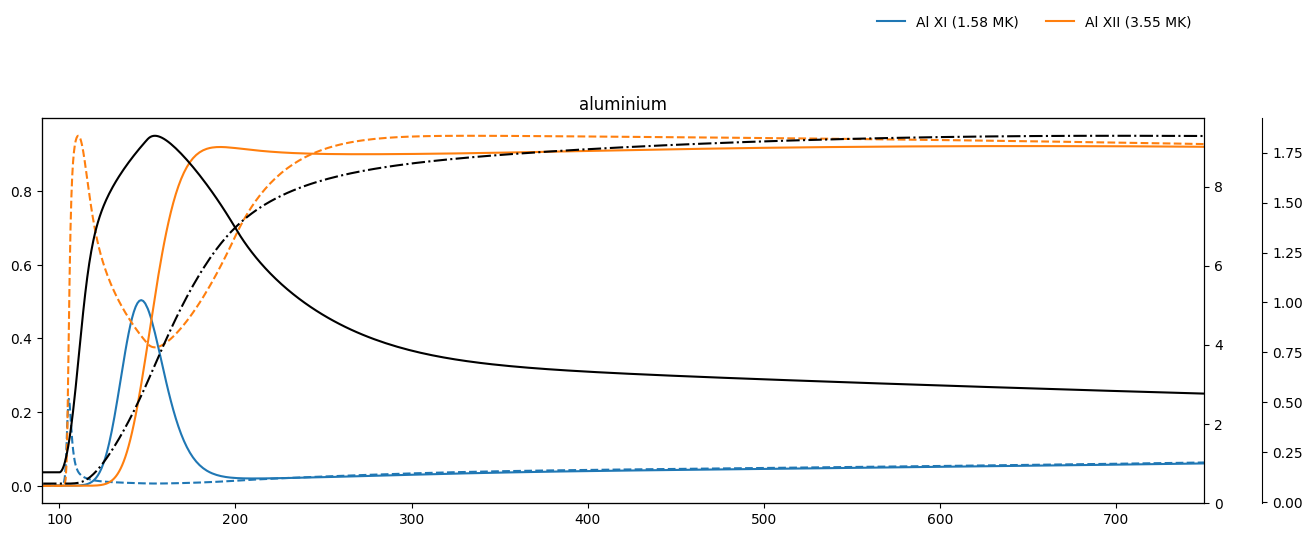

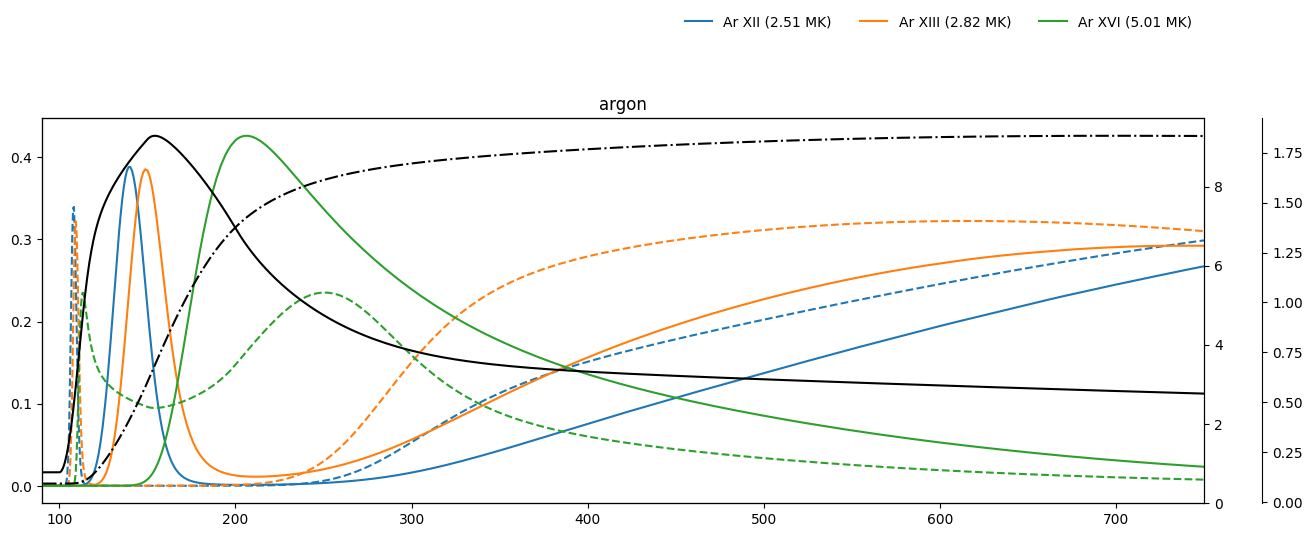

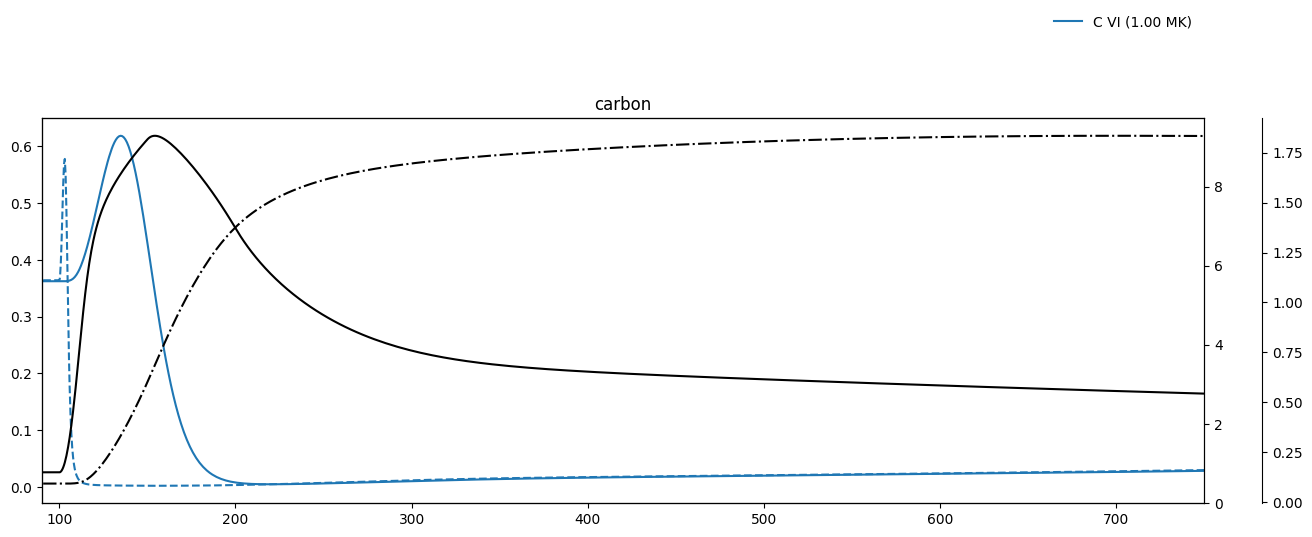

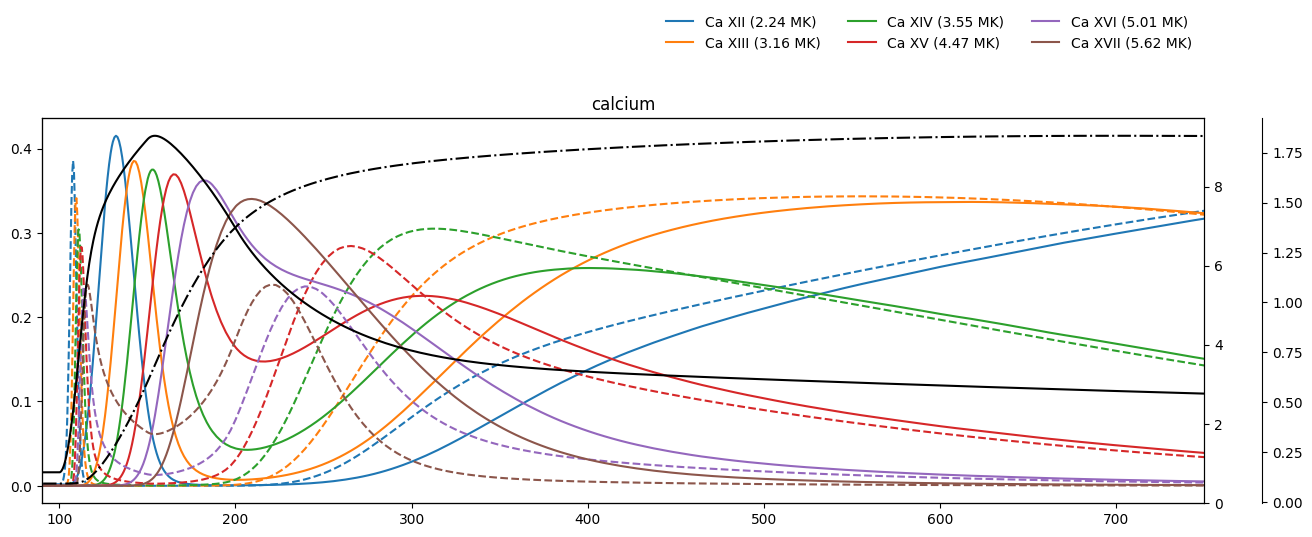

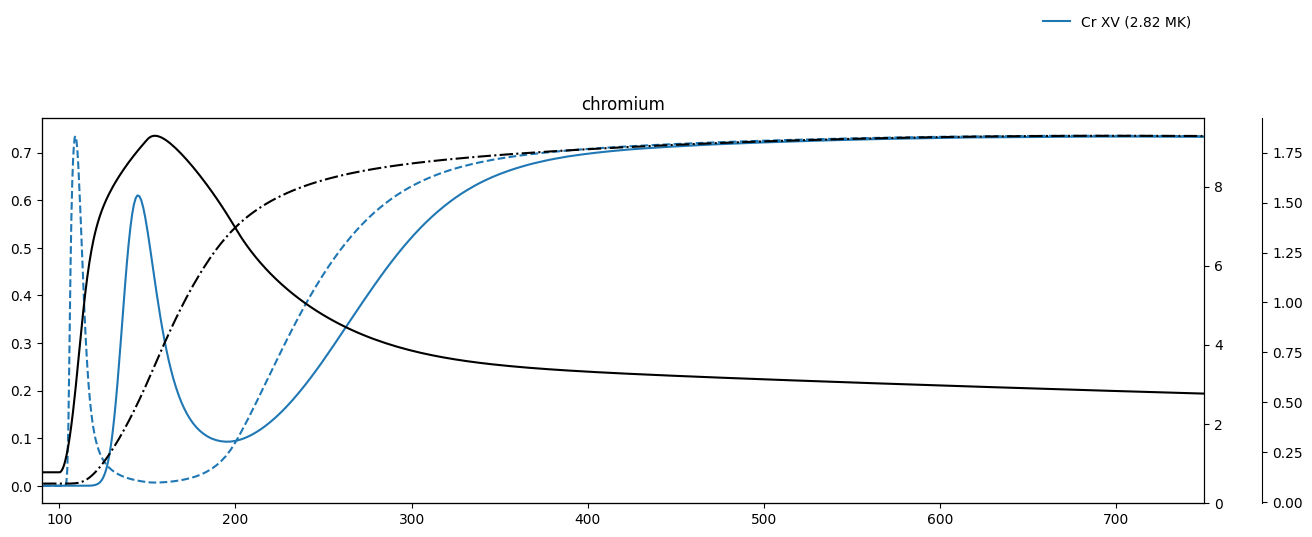

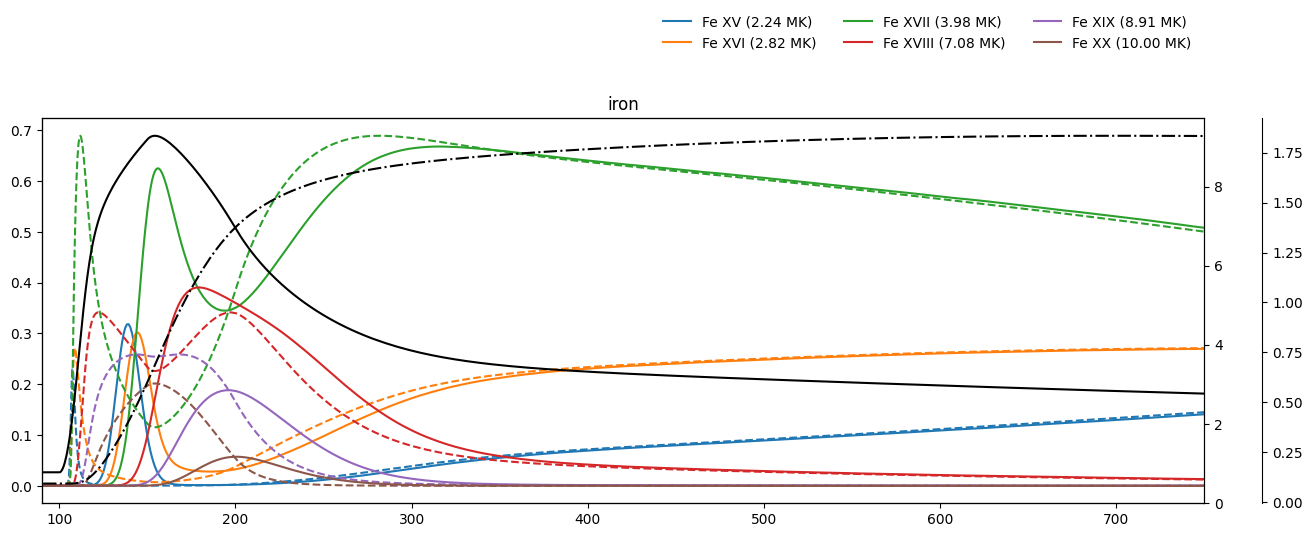

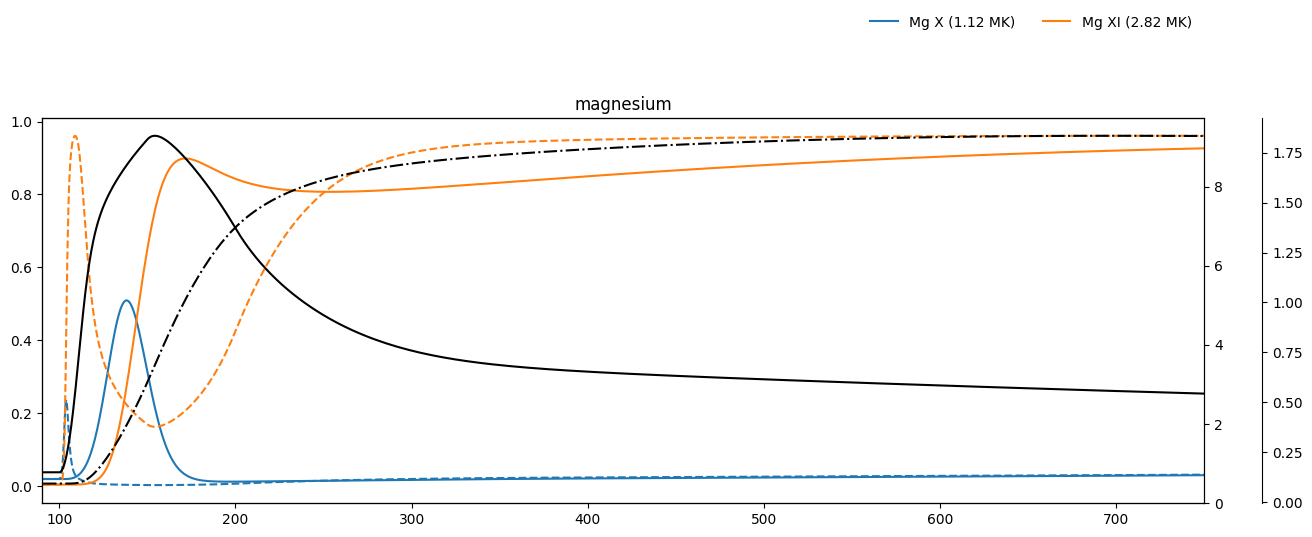

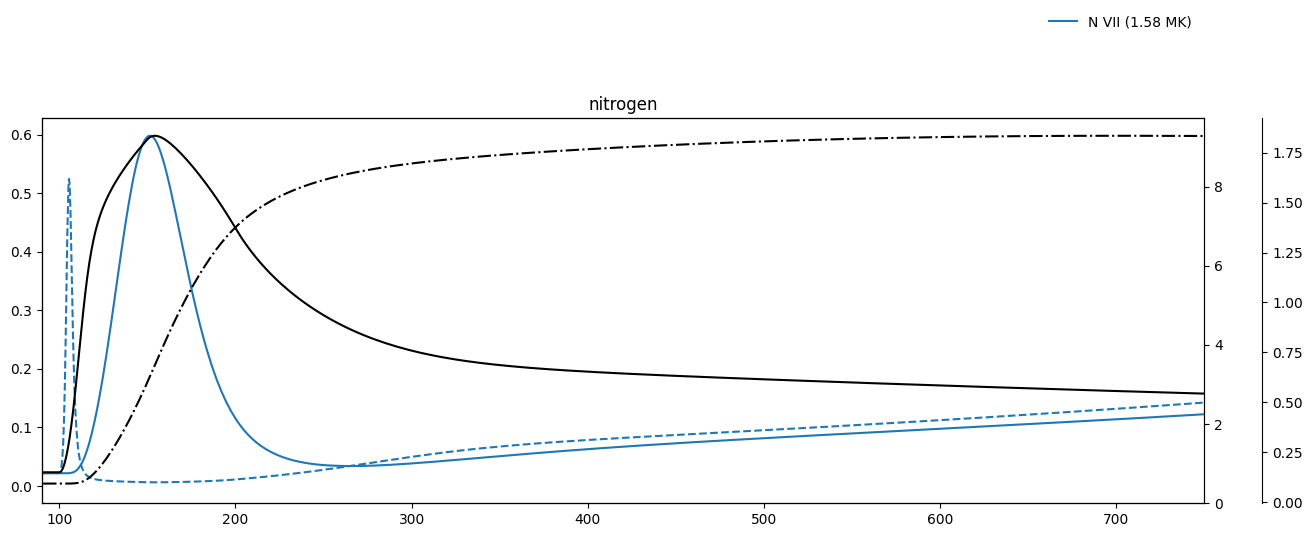

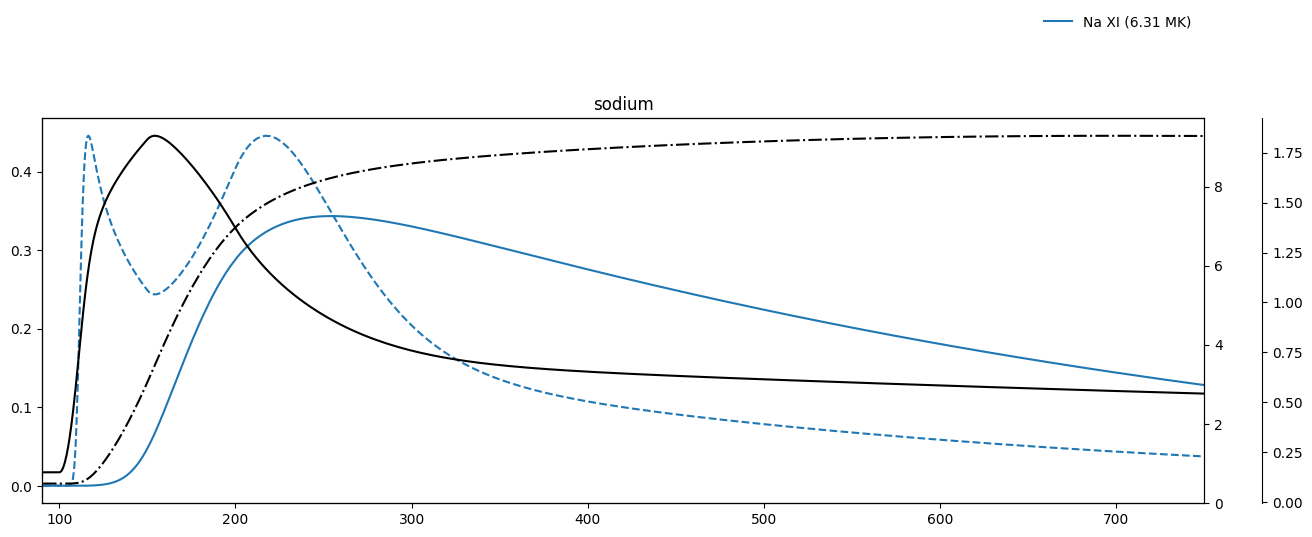

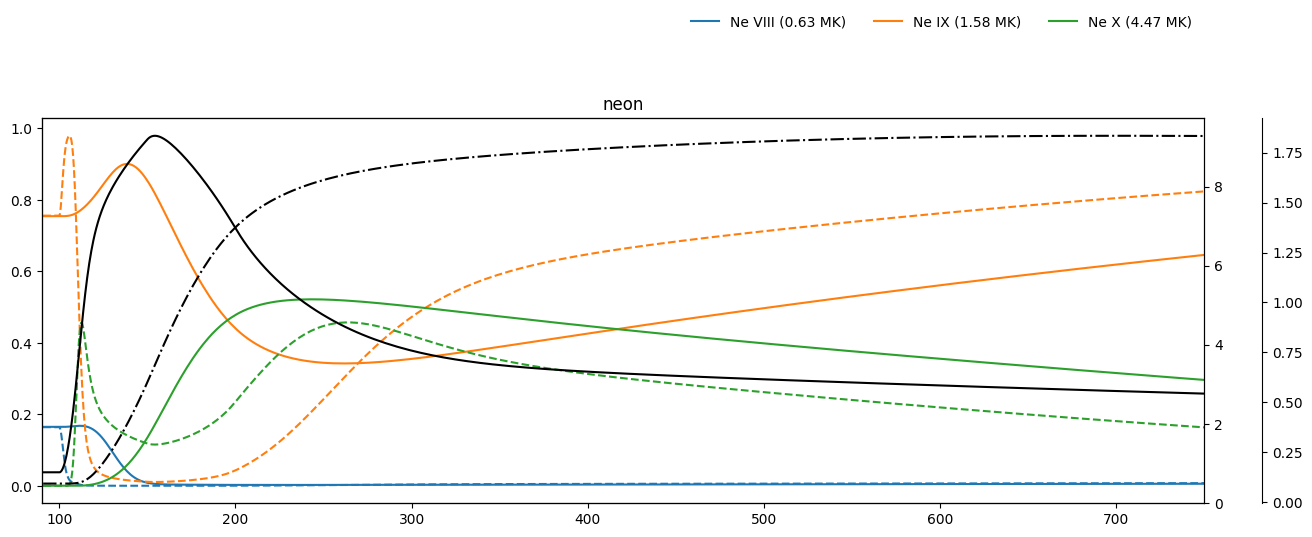

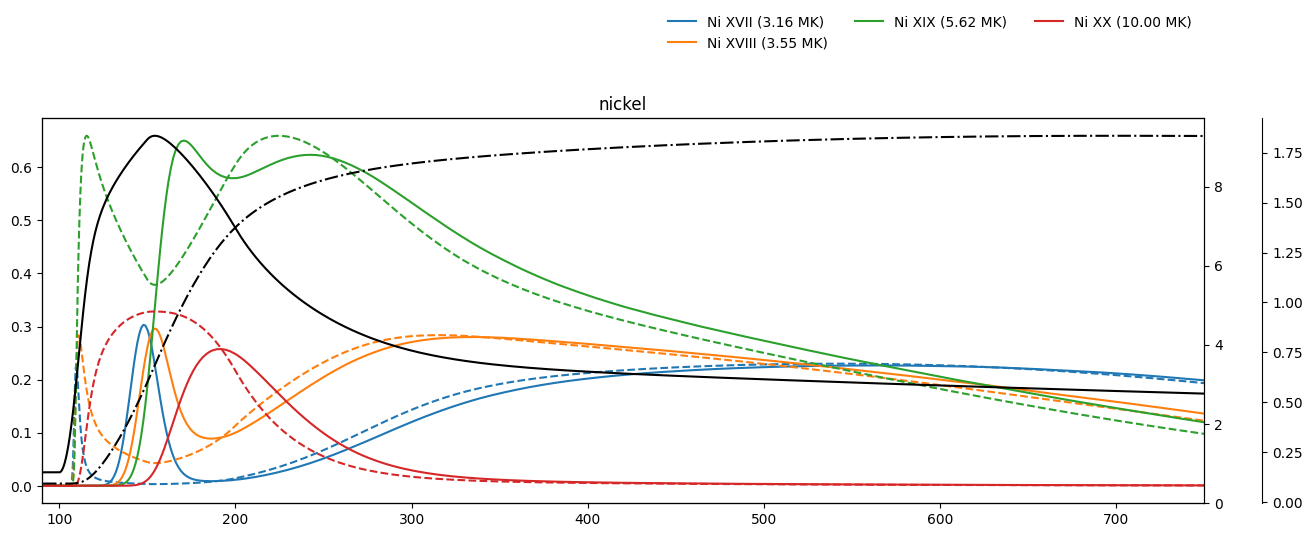

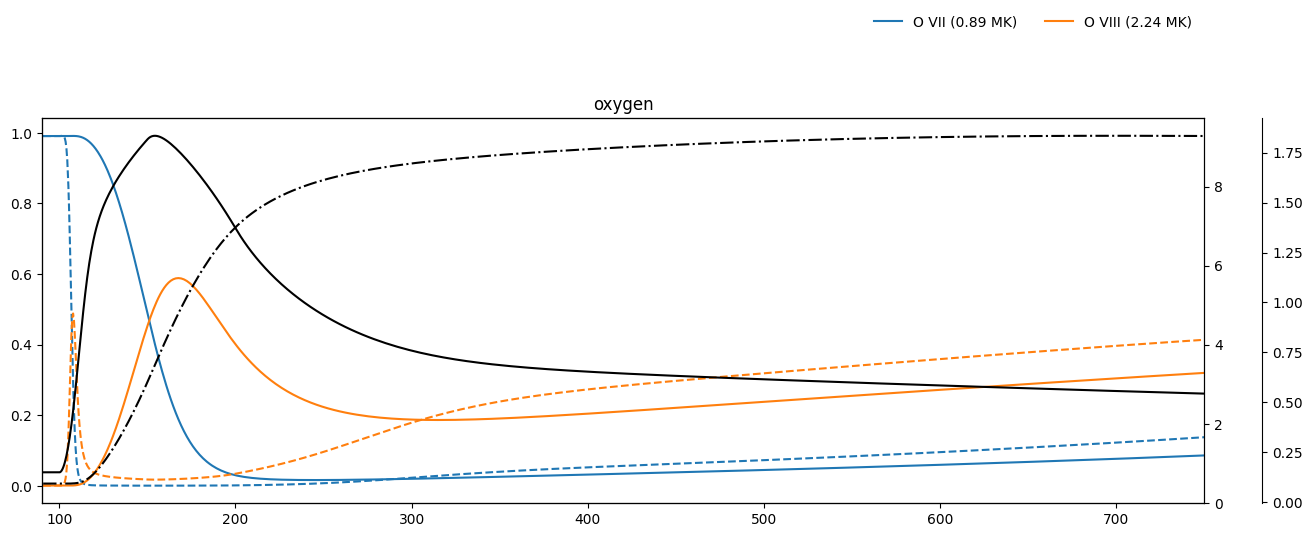

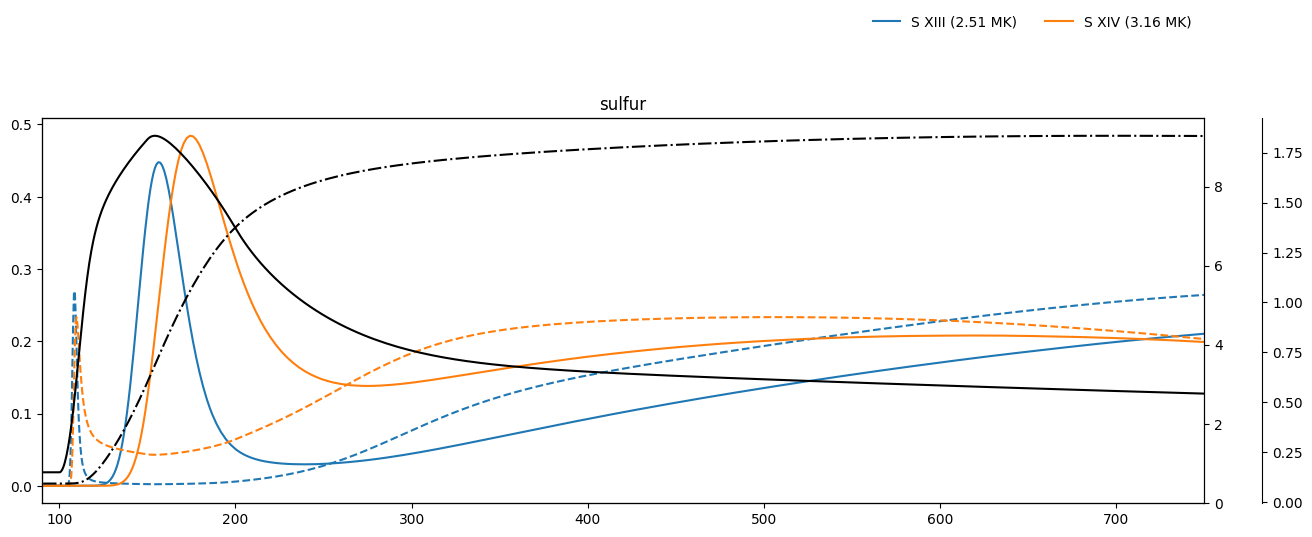

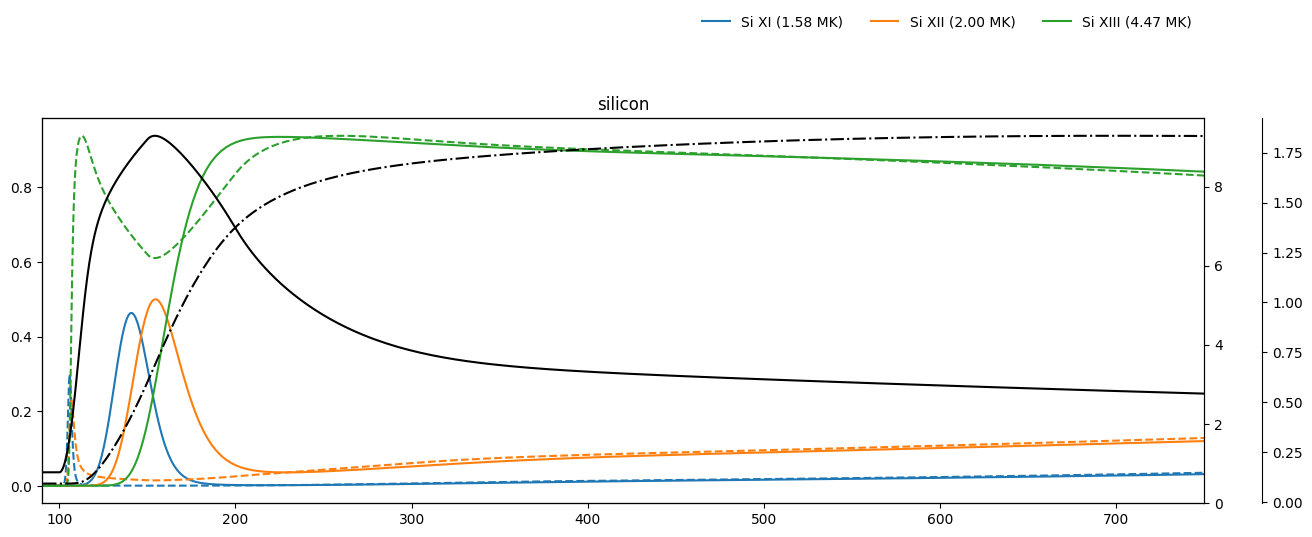

In [30]:
for el_name in elements:
    el = fiasco.Element(el_name, temperature_grid,)
    nei = non_equilibrium_ionization(el, time, electron_temperature, density, check_solution=True)
    ieq = equilibrium_ionization(el, electron_temperature)
    ionization_stages = np.unique(hot_line_table[hot_line_table['element'] == el.atomic_symbol]['ionization stage'])
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.05))
    for ion in el:
        if ion.ionization_stage in ionization_stages:
            l, = ax.plot(time, ieq[:, ion.charge_state], ls='--')
            ax.plot(time, nei[:, ion.charge_state], ls='-', color=l.get_color(),
                    label=f'{ion.ion_name_roman} ({ion.formation_temperature.to("MK"):.2f})')
    ax2.plot(time, electron_temperature.to('MK'), color='k')
    ax3.plot(time, density/1e9, color='k', ls='-.')
    ax.legend(loc='upper right', bbox_to_anchor=(1,1.3), ncol=3, frameon=False)
    ax.set_xlim(90,750)
    ax2.set_xlim(ax.get_xlim())
    ax.set_title(el.element_name)

Take the difference between the NEI and IEQ results

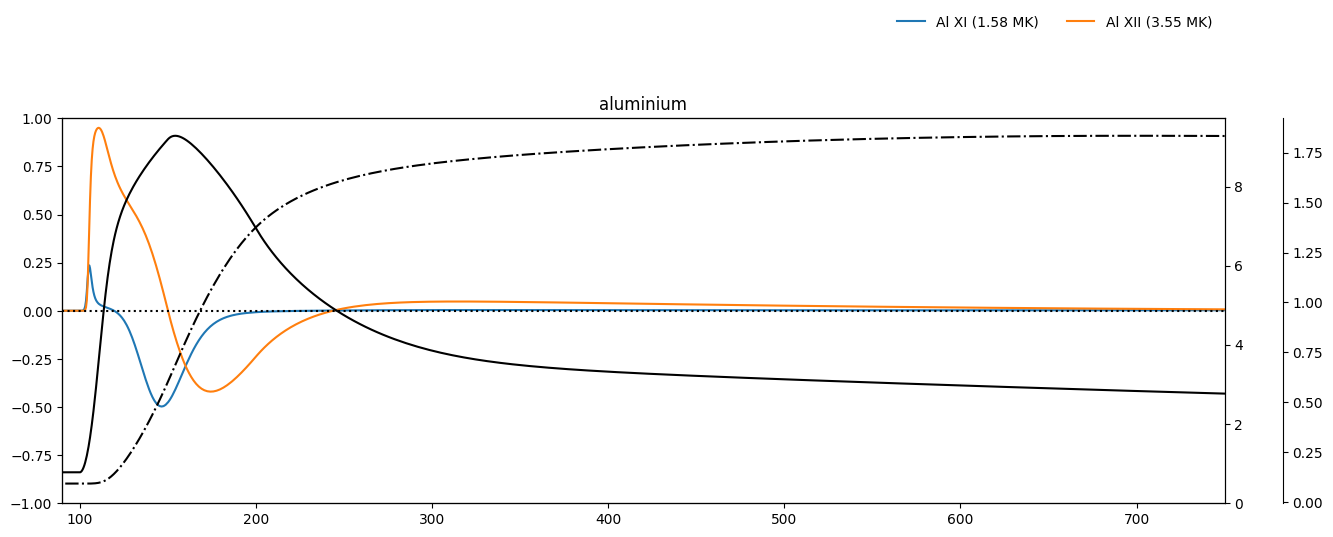

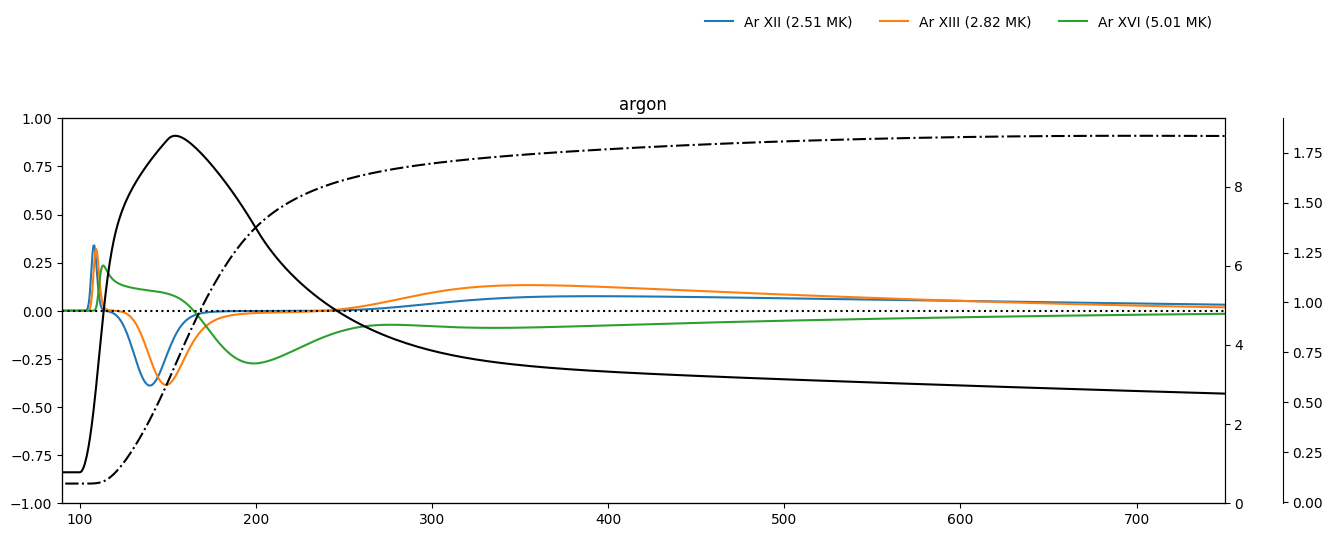

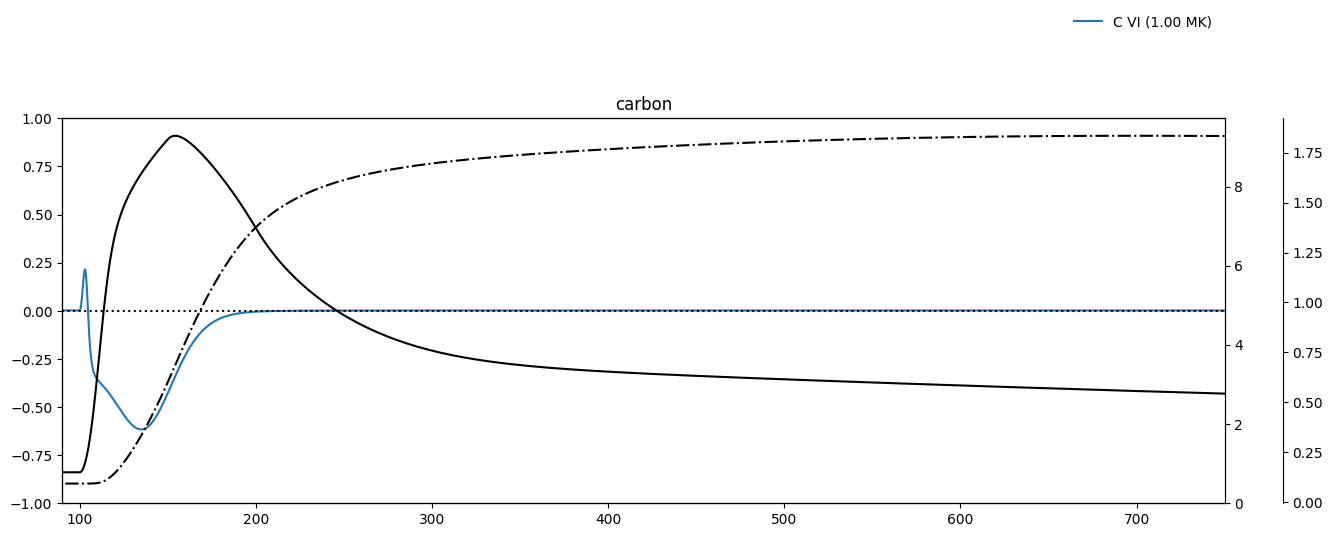

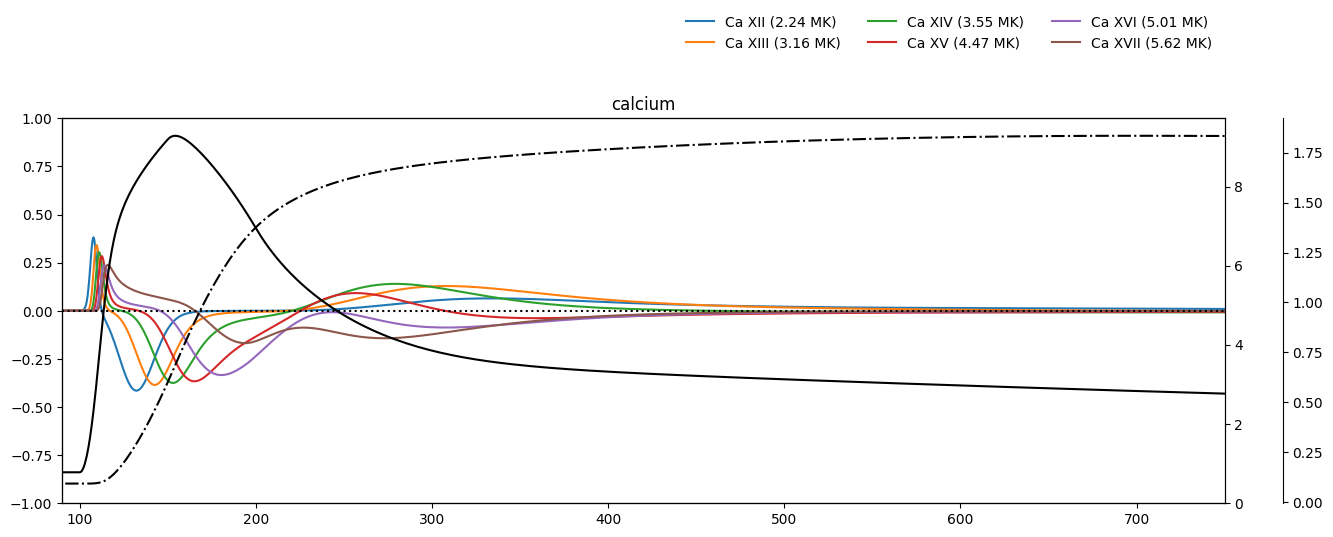

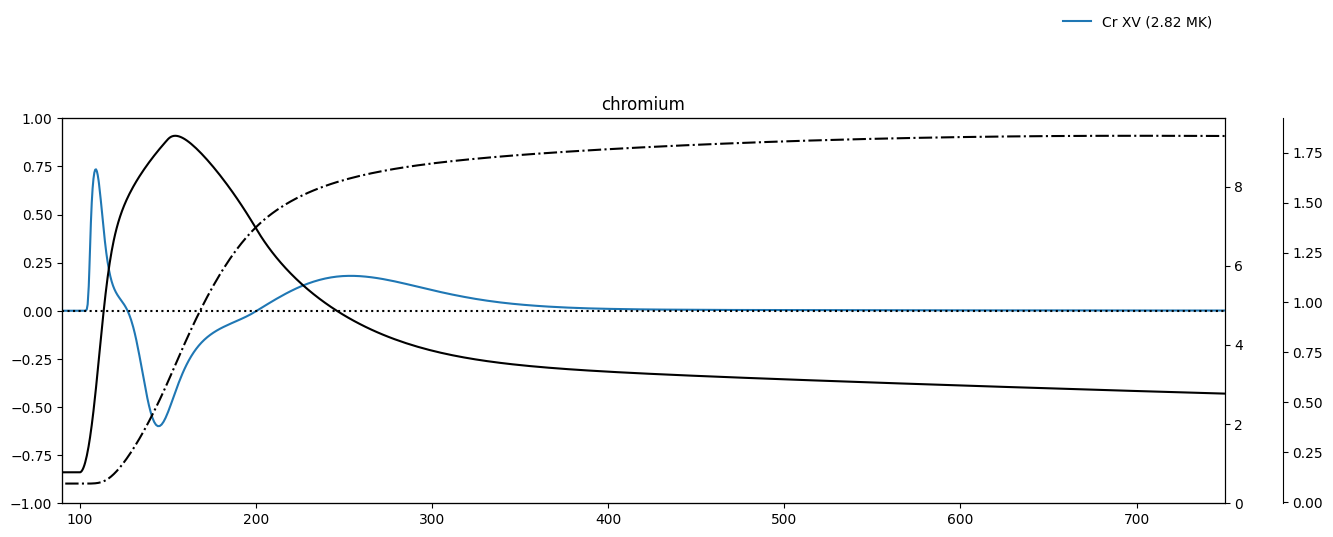

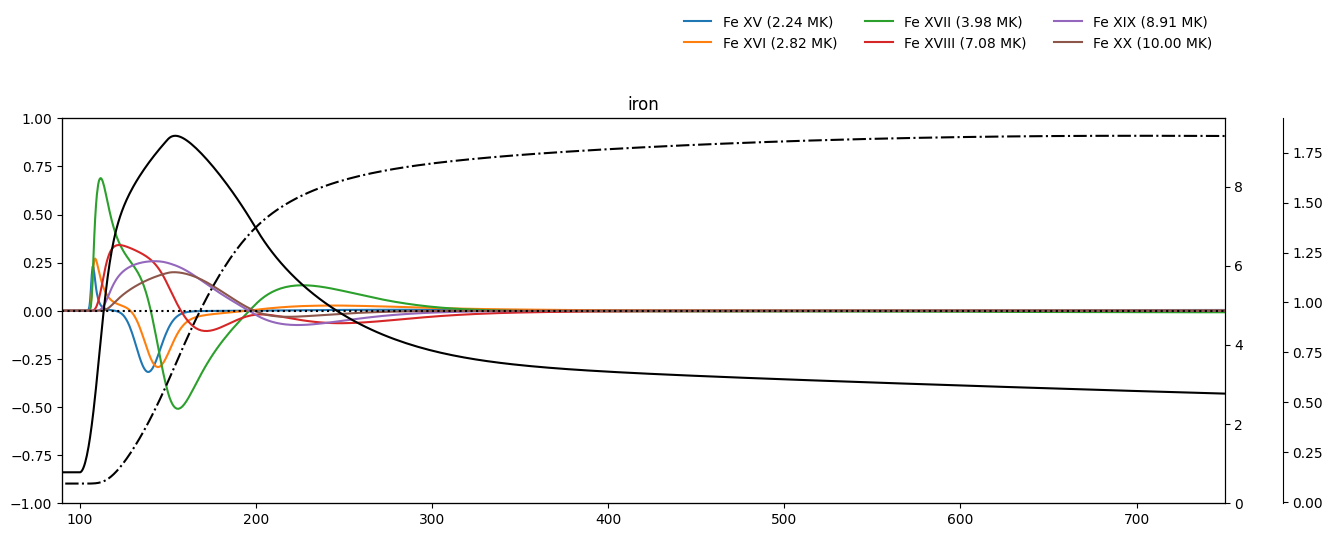

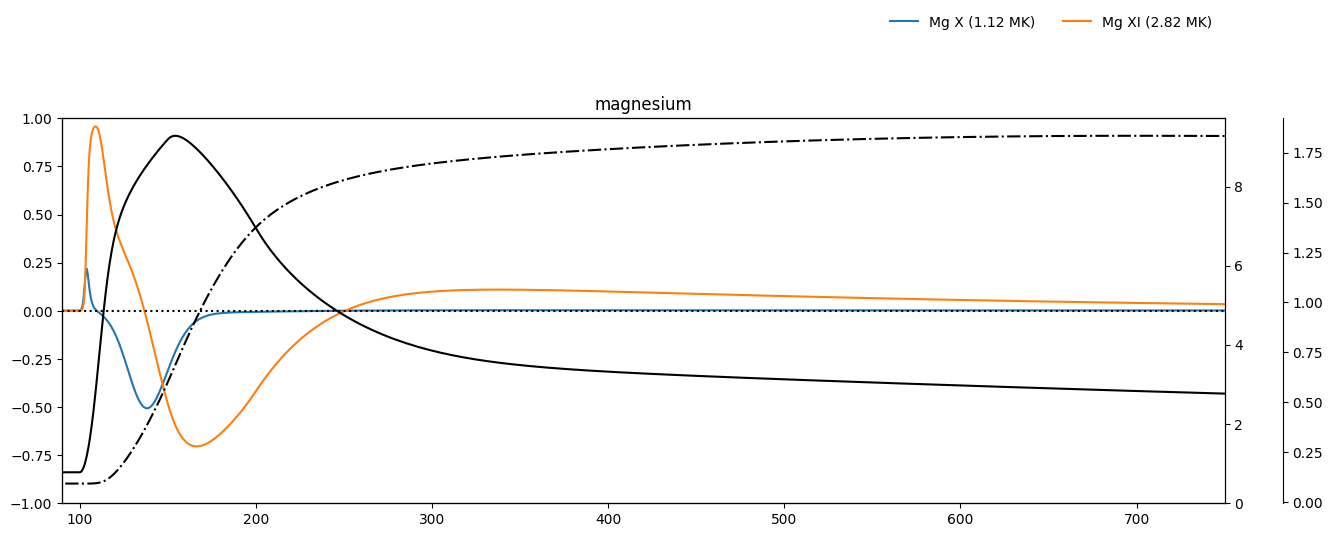

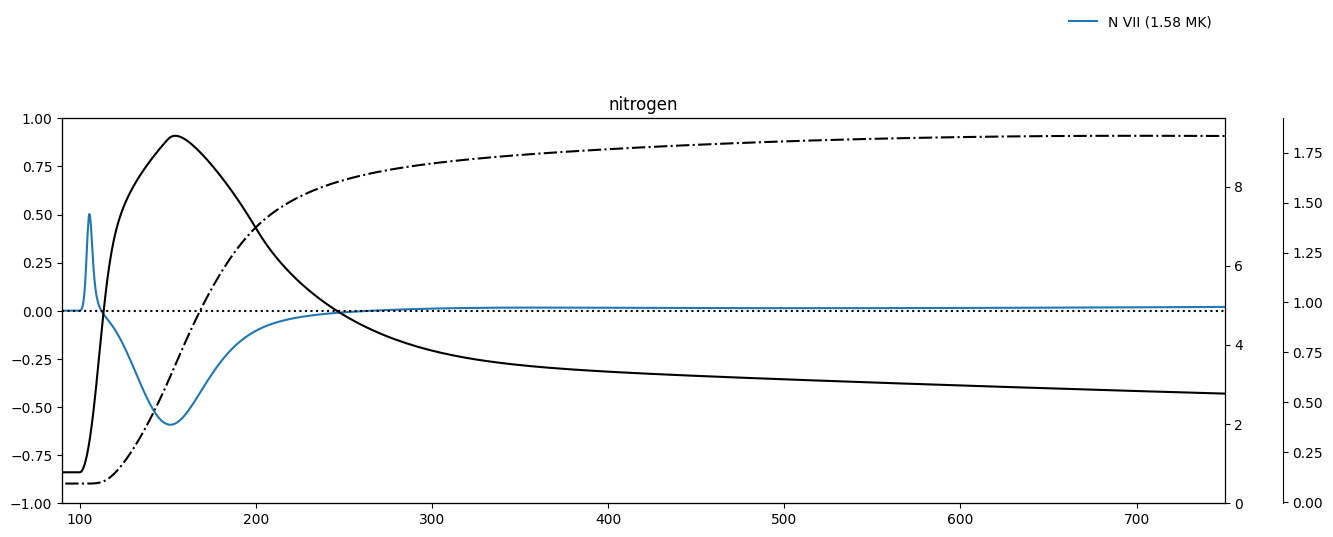

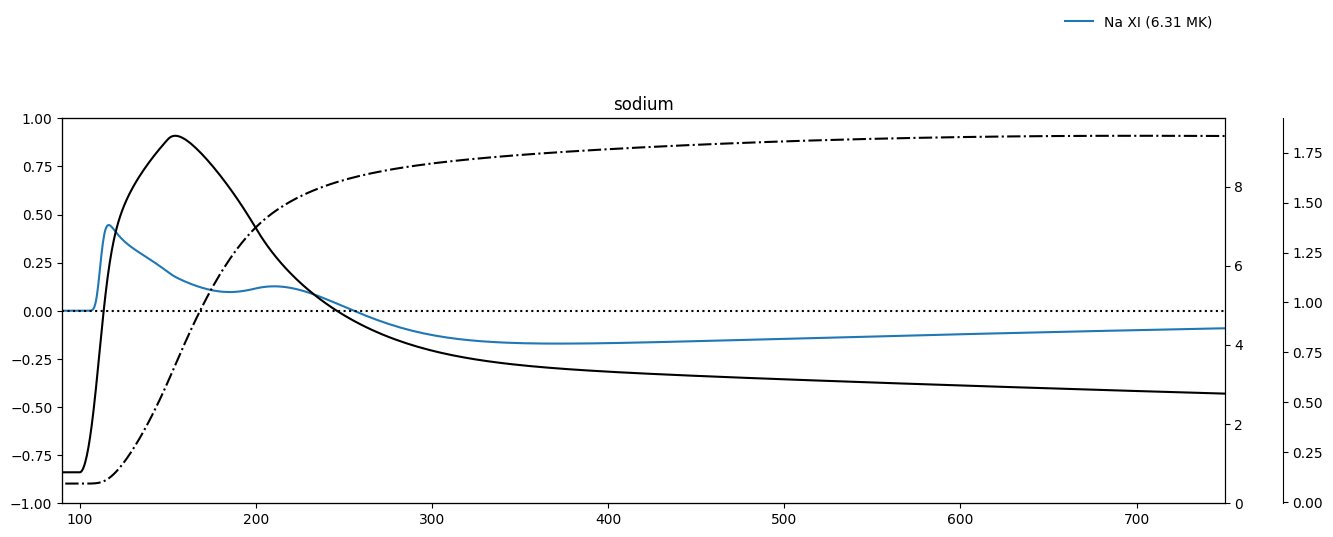

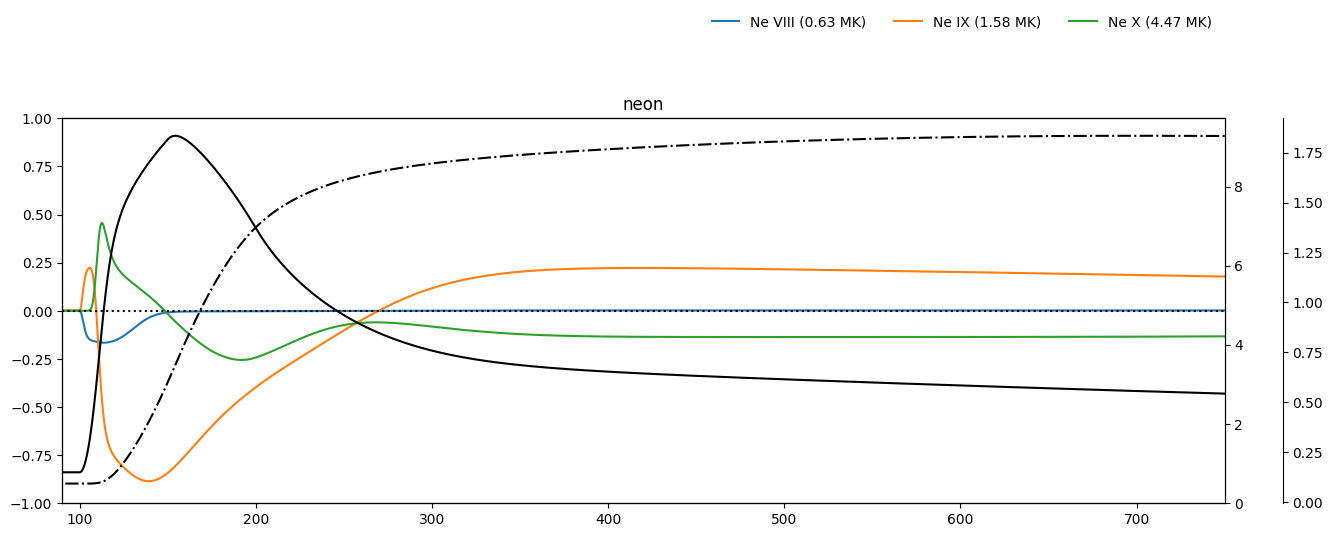

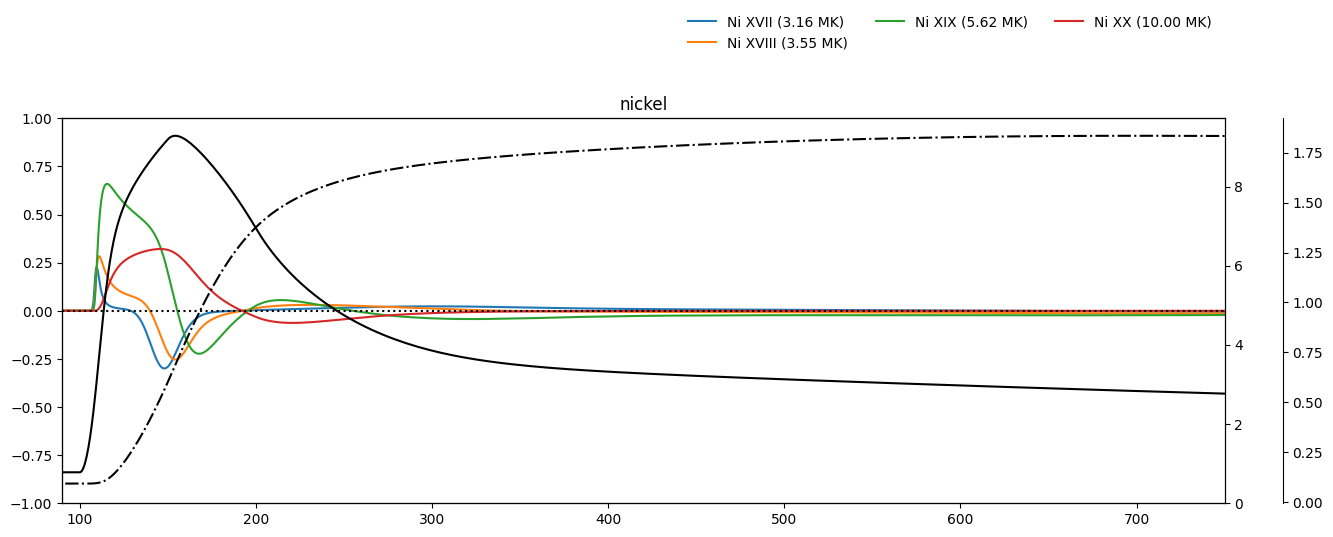

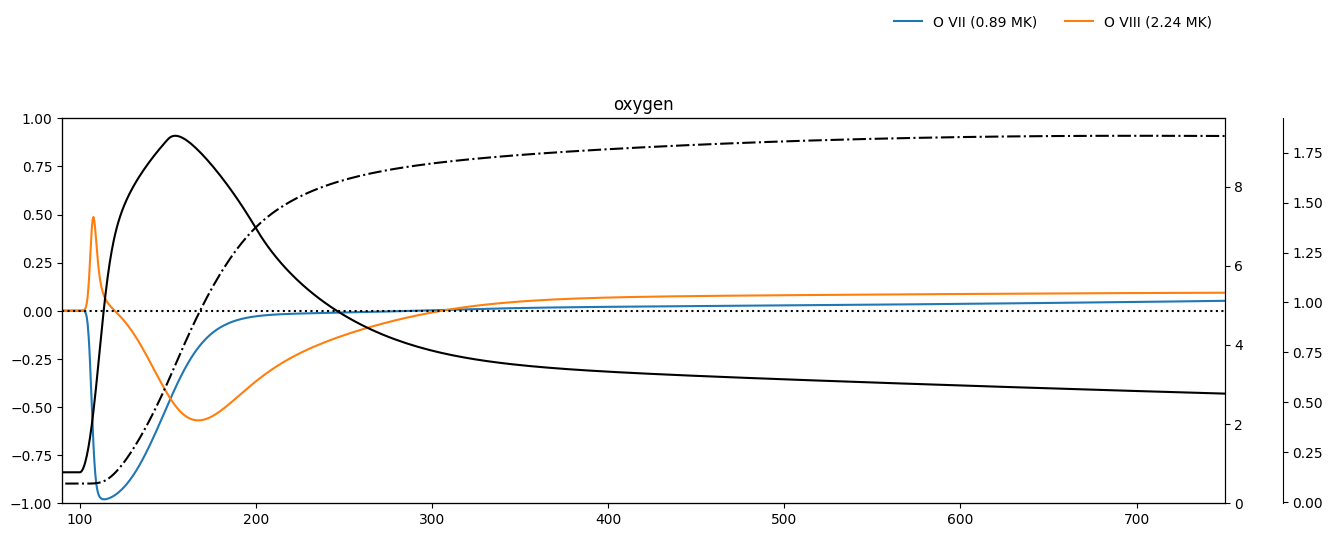

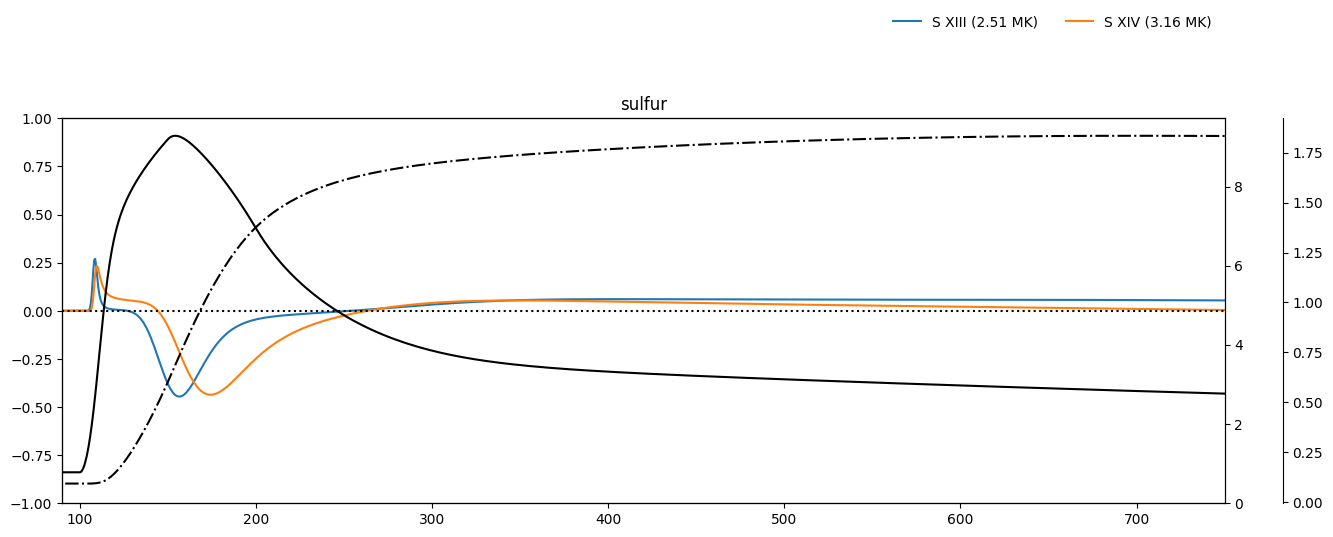

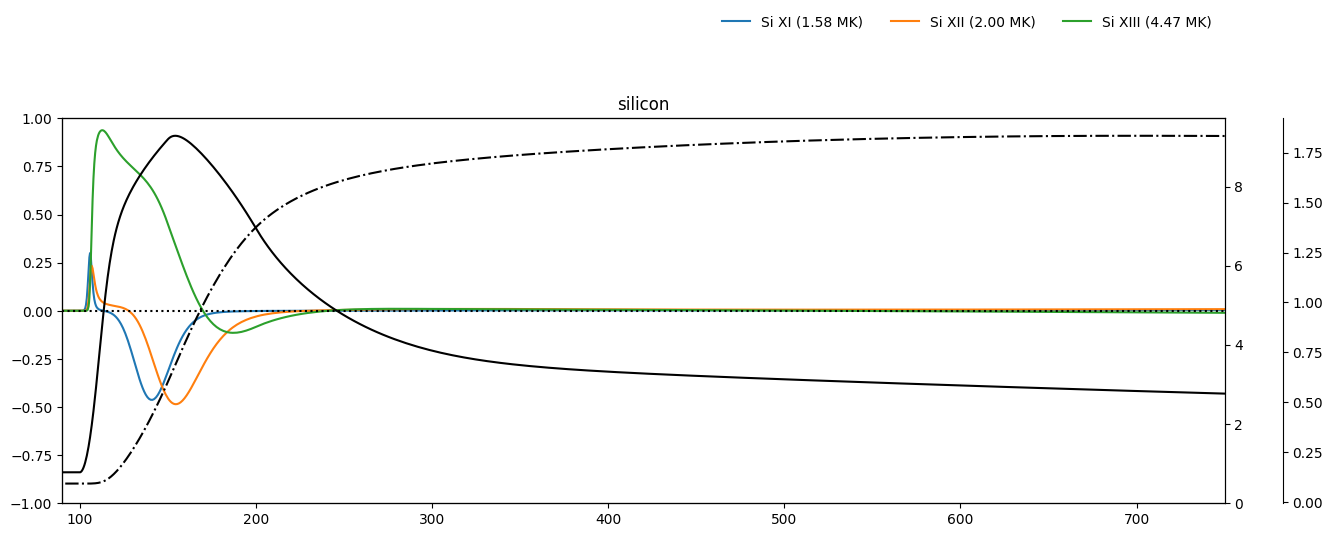

In [32]:
for el_name in elements:
    el = fiasco.Element(el_name, temperature_grid,)
    nei = non_equilibrium_ionization(el, time, electron_temperature, density, check_solution=True)
    ieq = equilibrium_ionization(el, electron_temperature)
    ionization_stages = np.unique(hot_line_table[hot_line_table['element'] == el.atomic_symbol]['ionization stage'])
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.05))
    for ion in el:
        if ion.ionization_stage in ionization_stages:
            ax.plot(time, ieq[:, ion.charge_state] - nei[:, ion.charge_state], ls='-',
                    label=f'{ion.ion_name_roman} ({ion.formation_temperature.to("MK"):.2f})')
    ax2.plot(time, electron_temperature.to('MK'), color='k')
    ax3.plot(time, density/1e9, color='k', ls='-.')
    ax.legend(loc='upper right', bbox_to_anchor=(1,1.3), ncol=3, frameon=False)
    ax.set_xlim(90,750)
    ax.set_ylim(-1, 1)
    ax2.set_xlim(ax.get_xlim())
    ax.set_title(el.element_name)
    ax.axhline(y=0, ls=':', color='k')

## Effective temperature

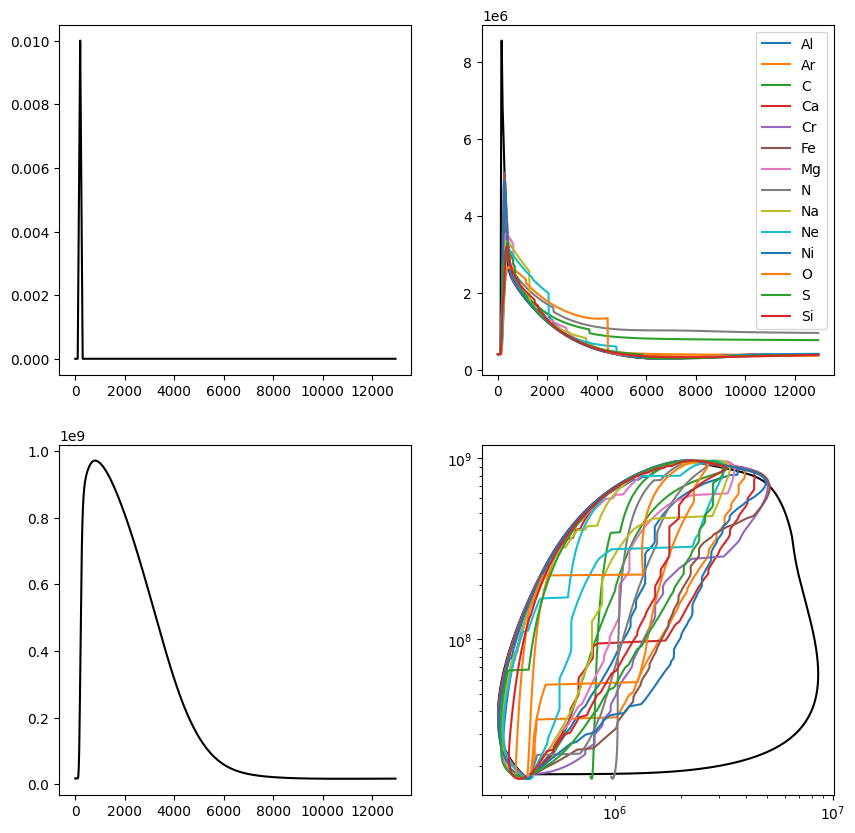

In [474]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.plot(time, heat, color='k')
ax2 = fig.add_subplot(222)
ax2.plot(time, electron_temperature, color='k')
ax3 = fig.add_subplot(223)
ax3.plot(time, density, color='k')
ax4 = fig.add_subplot(224)
ax4.plot(electron_temperature, density, color='k')
ax4.set_yscale('log')
ax4.set_xscale('log')
for el_name in elements:
    el = fiasco.Element(el_name, temperature_grid)
    T_eff = effective_temperature(el, time, electron_temperature, density)
    ax2.plot(time, T_eff, label=el.atomic_symbol)
    ax4.plot(T_eff, density)
ax2.legend()

## HYDRAD NEI Simulation

In the EBTEL simulations above, the density can rise unrealistically quickly (due to the lack of spatial dimension) such that the time taken to reach ionization equilibrium (and thus the impact of non-equilibrium ionization) may be underestimated. As such, we'll run a more sophisticated 1D simulation and compute the ion fractions for the same ions as above out of equilibrium to assess more accurately whether this is something we need to worry about in our observations.

In [657]:
elements

<Column name='element' dtype='str2' description='' length=14>
Al
Ar
 C
Ca
Cr
Fe
Mg
 N
Na
Ne
Ni
 O
 S
Si

In [695]:
hydrad_config = pydrad.configure.data.get_defaults()

In [696]:
hydrad_config['general']['loop_length'] = 2*(loop_length + hydrad_config['general']['footpoint_height'])
hydrad_config['general']['total_time'] = total_time
hydrad_config['general']['heat_flux_timestep_limit'] = 1e-5 * u.s
hydrad_config['general']['write_file_equation_terms'] = False
hydrad_config['general']['write_file_hydrogen_level_populations'] = False
hydrad_config['general']['write_file_ion_populations'] = True
hydrad_config['general']['write_file_physical'] = True
hydrad_config['general']['write_file_timescales'] = False
hydrad_config['initial_conditions']['footpoint_density'] = 2.5e9 * u.cm**(-3)
hydrad_config['initial_conditions']['footpoint_temperature'] = 1e4 * u.K
hydrad_config['initial_conditions']['heating_scale_height'] = 1e300 * u.cm
hydrad_config['radiation']['decouple_ionization_state_solver'] = True
hydrad_config['radiation']['elements_nonequilibrium'] = ['Ca', 'Fe', 'Mg', 'Ne', 'O', 'Si']
hydrad_config['radiation']['rates_dataset'] = 'chianti_v10'
hydrad_config['radiation']['use_power_law_radiative_losses'] = True
hydrad_config['grid']['adapt_every_n_time_steps'] = 10
hydrad_config['grid']['initial_refinement_level'] = 6
hydrad_config['grid']['maximum_refinement_level'] = 6
hydrad_config['grid']['refine_on_hydrogen_energy'] = False
hydrad_config['solver']['cutoff_temperature_fraction'] = 0.2
hydrad_config['solver']['cutoff_ion_fraction'] = 1e-6
hydrad_config['heating']['background']['use_initial_conditions'] = True
hydrad_config['heating']['electron_heating'] = 1.0
events = []
for event in ebtel_config['heating']['events']:
    event = event['event']
    events.append({
        'location': hydrad_config['general']['loop_length'] / 2,
        'scale_height': 1e300 * u.cm,
        'time_start': event['rise_start'] * u.s,
        'total_duration': (event['decay_end'] - event['rise_start']) * u.s,
        'rise_duration': (event['rise_end'] - event['rise_start']) * u.s,
        'decay_duration': (event['decay_end'] - event['decay_start']) * u.s,
        'rate': event['magnitude'] * u.Unit('erg cm-3 s-1'),
    })
hydrad_config['heating']['events'] = events

In [697]:
hydrad_config

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.1'},
 'history': {'extensions': [{'extension_class': 'astropy.io.misc.asdf.extension.AstropyAsdfExtension',
    'software': {'name': 'astropy', 'version': '4.0.1.post1'}},
   {'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.1'}}]},
 'general': {'footpoint_height': <Quantity 5.e+08 cm>,
  'force_single_fluid': False,
  'heat_flux_limiting_coefficient': 0.167,
  'heat_flux_timestep_limit': <Quantity 1.e-05 s>,
  'logging_frequency': 1000,
  'loop_inclination': <Quantity 0. deg>,
  'loop_length': <Quantity 90. Mm>,
  'minimum_collisional_coupling_timescale': <Quantity 0.01 s>,
  'output_interval': <Quantity 1. s>,
  'total_time': <Quantity 13000. s>,
  'use_kinetic_model': False,
  'write_file_equation_terms': False,
  'write_file_hydrogen_level_populations': False,
  'write_file_i

In [698]:
conf = pydrad.configure.Configure(hydrad_config)

In [700]:
conf.setup_simulation('hydrad_simulations/hydrad-moxsi-nei-higher-cutoff',
                      '/Users/wtbarnes/Documents/codes/HYDRAD/',
                      overwrite=True)

INFO: 

Calculating initial hydrostatic conditions...

Peak heating range = 1.3062e-06 -> 1.3092e-06 erg cm^-3 s^-1

Optimum peak heating rate = 1.3063e-06 erg cm^-3 s^-1

Writing initial conditions file...

Done!

 [pydrad.configure.util]


In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/mesh.cpp:17:
In file included from ../source/mesh.h:13:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
In file included from ../source/eqns.cpp:19:
../source/eqns.h:38:31: warning: default member initializer for non-static data member is a C++11 extension [-Wc++11-extensions]
    double Tc, Te_max, old_Tc = 0.0;
                              ^
1 warning generated.
 [pydrad.configure.util]


In [723]:
strand = pydrad.parse.Strand('hydrad_simulations/hydrad-moxsi-nei-higher-cutoff/')

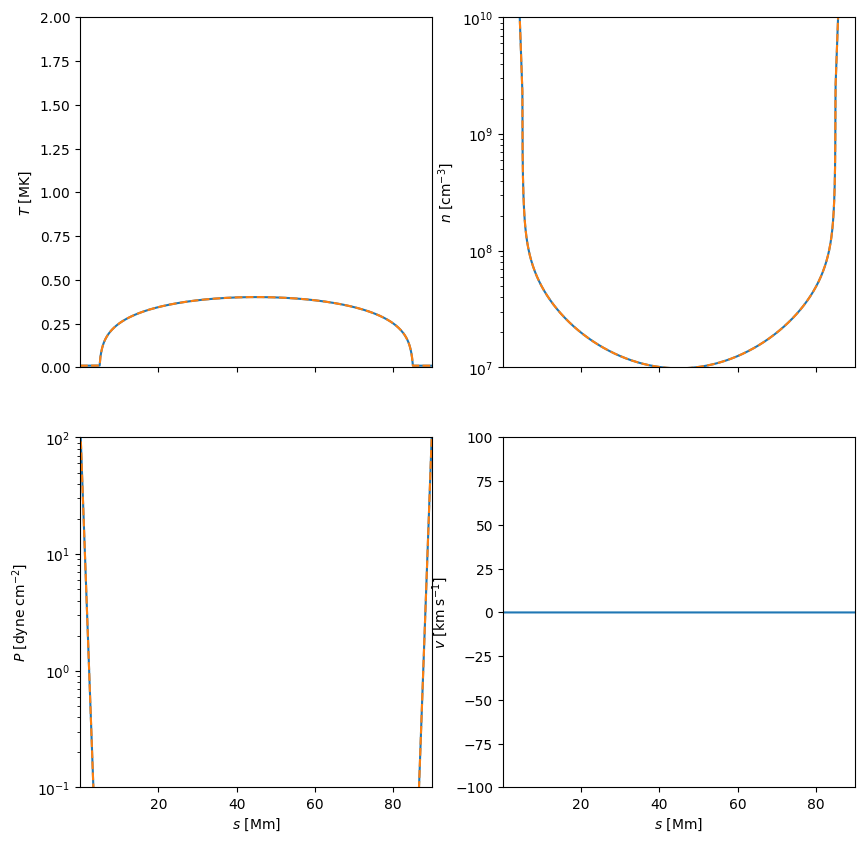

In [624]:
strand.initial_conditions.peek(limits={'temperature': [0,2], 'density': [1e7, 1e10]})

Compare the initial conditions of HYDRAD run...

In [590]:
strand.initial_conditions.spatial_average(
    'electron_temperature',
    bounds=strand.config['general']['loop_length']*(0.25, 0.75),).to('MK')

<Quantity 0.38303183 MK>

In [591]:
strand.initial_conditions.spatial_average(
    'electron_density',
    bounds=strand.config['general']['loop_length']/2*(0.25, 1.25),) / 1e9

<Quantity 0.01996762 1 / cm3>

To that of EBTEL

In [592]:
density[0] / 1e9

<Quantity 0.01798226 1 / cm3>

In [593]:
electron_temperature[0].to('MK')

<Quantity 0.4106181 MK>

(<Figure size 1000x1000 with 8 Axes>,
 array([<AxesSubplot:ylabel='$s$ [Mm]'>, <AxesSubplot:ylabel='$s$ [Mm]'>,
        <AxesSubplot:ylabel='$s$ [Mm]'>,
        <AxesSubplot:xlabel='$t$ [s]', ylabel='$s$ [Mm]'>], dtype=object))

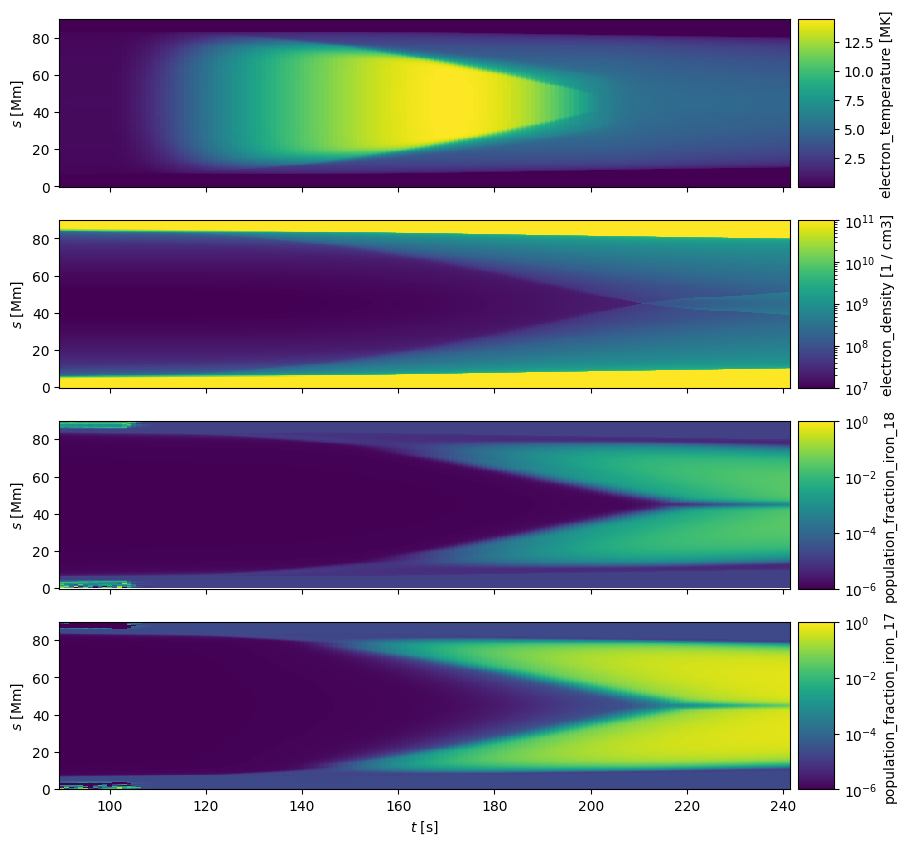

In [724]:
pydrad.visualize.plot_time_distance(
    strand[90:-1],
    ['electron_temperature', 'electron_density','population_fraction_iron_18', 'population_fraction_iron_17'],
    0.5*u.Mm,
    time_unit='s',
    space_unit='Mm',
    units={'electron_temperature': 'MK'},
    norm={'population_fraction_iron_18': matplotlib.colors.LogNorm(vmin=1e-6, vmax=1),
          'population_fraction_iron_17': matplotlib.colors.LogNorm(vmin=1e-6, vmax=1),
          'electron_density': matplotlib.colors.LogNorm(vmin=1e7, vmax=1e11)},
)

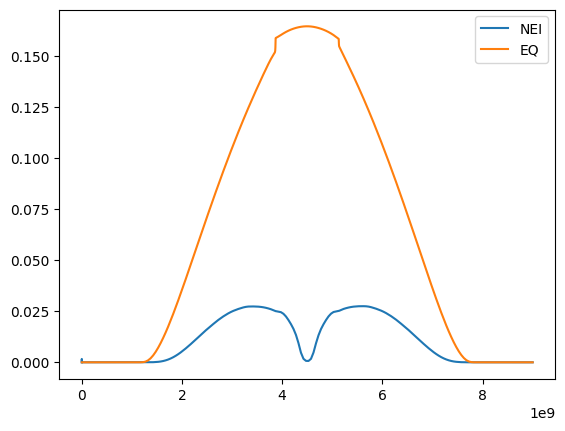

In [740]:
i_time = -1
plt.plot(strand[i_time].grid_centers, strand[i_time].population_fraction_iron_18, label='NEI')
plt.plot(strand[i_time].grid_centers, equilibrium_ionization(fiasco.Element('Fe', temperature_grid),strand[i_time].electron_temperature)[:,17], label="EQ")
plt.legend()

In [ ]:
pydrad.visualize.plot_time_mesh()

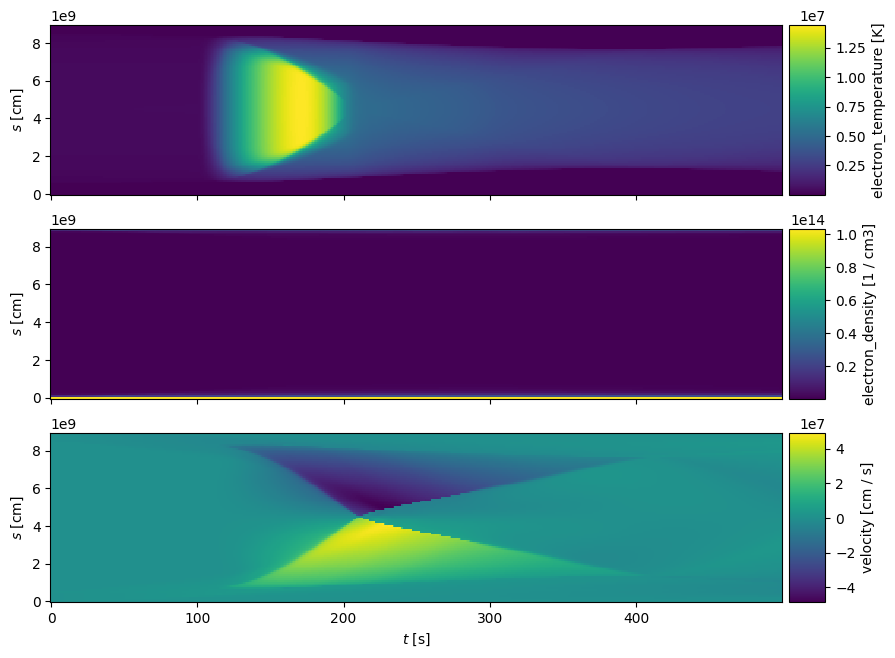

In [668]:
strand[:500].peek_time_distance()

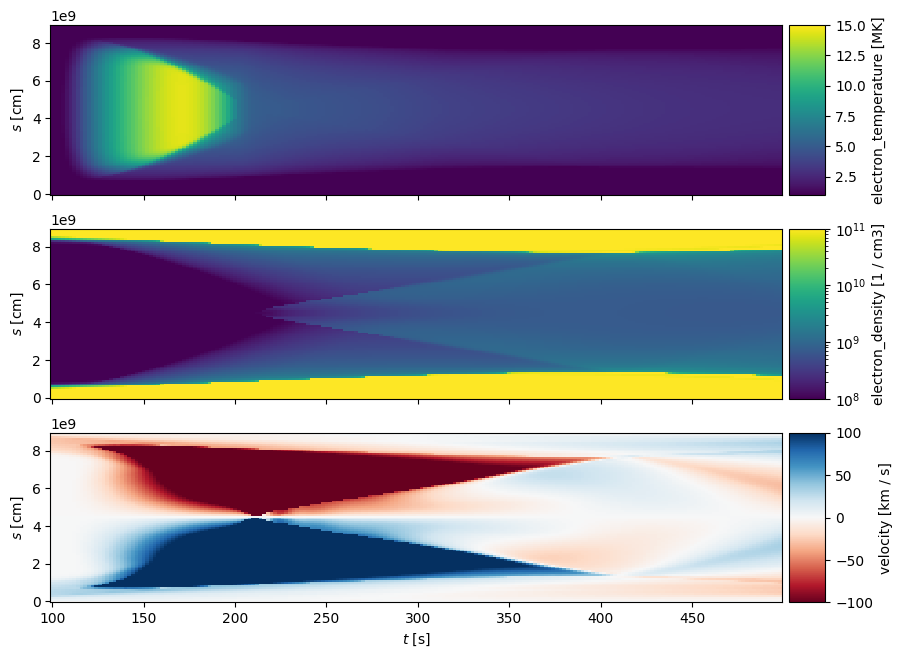

In [691]:
strand[100:500:2].peek_time_distance(cmap={'velocity':'RdBu'},
                                      norm={'electron_density': matplotlib.colors.LogNorm(vmin=1e8, vmax=1e11),
                                            'velocity': matplotlib.colors.Normalize(vmin=-100, vmax=100),
                                            'electron_temperature': matplotlib.colors.Normalize(vmin=1, vmax=15)},
                                      units={'velocity': 'km / s',
                                             'electron_temperature': "MK"})

In [717]:
from sunpy.coordinates.utils import solar_angle_equivalency
from sunpy.coordinates import get_earth
(150 * u.Mm).to('arcsec', equivalencies=solar_angle_equivalency(get_earth()))

INFO: Apparent body location accounts for 500.01 seconds of light travel time [sunpy.coordinates.ephemeris]


<Quantity 206.40326237 arcsec>

In [722]:
foo = 'foo \n'
print(foo)
print(foo.strip())

foo 

foo


In [755]:
strand = pydrad.parse.Strand('hydrad_simulations/hydrad-moxsi-no-nei/')[90:5000]

(0.0, 5000.0)

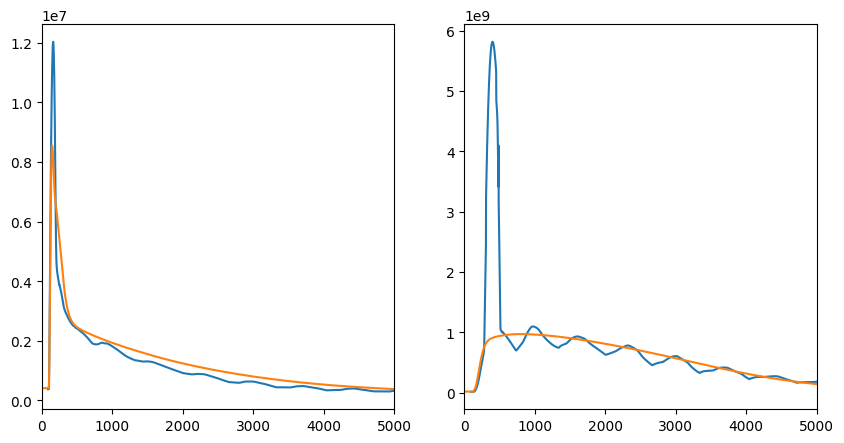

In [757]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(strand.time, strand.spatial_average('electron_temperature', bounds=strand.loop_length/2*(0.25, 1.25)))
plt.plot(time, electron_temperature)
plt.xlim(0,5000)
plt.subplot(122)
plt.plot(strand.time, strand.spatial_average('electron_density', bounds=strand.loop_length/2*(0.25, 1.25)))
plt.plot(time, density)
plt.xlim(0,5000)

## Sandbox

In [3]:
from collections import OrderedDict

In [4]:
total_time = 1.3e4 * u.s
loop_length = 40 * u.Mm
heating_background = 2.75e-5 * u.Unit('erg cm-3 s-1')

# setup config
ebtel_config = {
    'total_time': total_time.to_value('s'),
    'tau': 1.0,
    'tau_max': 1e+300,
    'loop_length': loop_length.to_value('cm'),
    'saturation_limit': 1.0,
    'force_single_fluid': False,
    'use_c1_loss_correction': True,
    'use_c1_grav_correction': True,
    'use_flux_limiting': True,
    'calculate_dem': False,
    'dem': OrderedDict({
        'use_new_method': True,
        'temperature': {
            'bins': 451,
            'log_min': 4,
            'log_max': 8.5
        }
    }),
    'save_terms': False,
    'use_adaptive_solver': True,
    'adaptive_solver_error': 1e-10,
    'adaptive_solver_safety': 0.5,
    'c1_cond0': 6.0,
    'c1_rad0': 0.6,
    'helium_to_hydrogen_ratio': 0.075,
    'surface_gravity': 1.0,
    'heating': OrderedDict({
        'background': heating_background.to_value('erg cm-3 s-1'),
        'partition': 1.0,
    }),
}

# setup heating
duration = 200 * u.s
t_0 = 100 * u.s
wait_time = 1500 * u.s
number_events = 1
heating_rate = 0.05 * u.Unit('erg cm-3 s-1')
start_times = t_0 + (duration + wait_time) * np.arange(number_events)
events = []
for st in start_times:
    events.append(
        {'event': {'magnitude': heating_rate.to_value('erg cm-3 s-1'),
                   'rise_start': st.to_value('s'),
                   'rise_end': (st + duration/2).to_value('s'),
                   'decay_start': (st + duration/2).to_value('s'),
                   'decay_end': (st + duration).to_value('s')}}
    )
ebtel_config['heating']['events'] = events

In [5]:
ebtel_config

{'total_time': 13000.0,
 'tau': 1.0,
 'tau_max': 1e+300,
 'loop_length': 4000000000.0,
 'saturation_limit': 1.0,
 'force_single_fluid': False,
 'use_c1_loss_correction': True,
 'use_c1_grav_correction': True,
 'use_flux_limiting': True,
 'calculate_dem': False,
 'dem': OrderedDict([('use_new_method', True),
              ('temperature', {'bins': 451, 'log_min': 4, 'log_max': 8.5})]),
 'save_terms': False,
 'use_adaptive_solver': True,
 'adaptive_solver_error': 1e-10,
 'adaptive_solver_safety': 0.5,
 'c1_cond0': 6.0,
 'c1_rad0': 0.6,
 'helium_to_hydrogen_ratio': 0.075,
 'surface_gravity': 1.0,
 'heating': OrderedDict([('background', 2.75e-05),
              ('partition', 1.0),
              ('events',
               [{'event': {'magnitude': 0.05,
                  'rise_start': 100.0,
                  'rise_end': 200.0,
                  'decay_start': 200.0,
                  'decay_end': 300.0}}])])}

In [6]:
run_ebtel(ebtel_config, '/Users/wtbarnes/Documents/codes/ebtelPlusPlus/')

{'time': array([0.00000000e+00, 2.00000000e+00, 6.50000000e+00, ...,
        1.25817733e+04, 1.27264025e+04, 1.28897902e+04]),
 'electron_temperature': array([1007727., 1007750., 1007848., ..., 1024449., 1024248., 1024022.]),
 'ion_temperature': array([1007727., 1007702., 1007596., ..., 1020788., 1020599., 1020385.]),
 'density': array([1.771306e+08, 1.771304e+08, 1.771296e+08, ..., 1.598711e+08,
        1.601044e+08, 1.603605e+08]),
 'electron_pressure': array([0.02463291, 0.02463344, 0.02463572, ..., 0.0226016 , 0.02263016,
        0.02266135]),
 'ion_pressure': array([0.02302641, 0.02302582, 0.02302329, ..., 0.02105208, 0.02107891,
        0.0211082 ]),
 'velocity': array([-2068.353, -2037.979, -1907.785, ..., 20524.63 , 19950.89 ,
        19326.38 ]),
 'heat': array([2.75e-05, 2.75e-05, 2.75e-05, ..., 2.75e-05, 2.75e-05, 2.75e-05])}